# Deep Reconciliation of Categorical Colour perception

We perceive colours categorically. Our perceptual system separates a continuous space into distinct categories. The most prominent example is the rainbow, there are no discontinuities in its colour spectrum, yet we see discrete bands. The underlying reason, particularly the role of language, has spawned a heated debate between universalists and relativists. We reconcile these two explanations by studying vision-language and pure-vision deep neural networks (DNN). The results of our odd-one-out experiments show that pure-vision models (e.g., ImageNet object recognition networks) explain 85% of human data. In turn, suggesting a large part of our categorical colour perception is purely driven by visual signals. The remaining 15% is explained with vision-language models (e.g., CLIP text-image matching networks) even when tested without their language module. In turn, suggesting colour categories is a free-from-language representation, yet linguistic colour terms have influenced its development. We investigated whether colour categories emerge in all pure-vision models by studying Taskonomy networks trained on 24 visual tasks. Human-like colour categories appear only in less than half of those models, namely, networks trained on semantic (e.g., image segmentation, object recognition, and scene classification) or 3D tasks (e.g., shade from shaping, surface normal prediction, and depth estimation). Our results show low-level tasks (e.g., autoencoding and denoising) never obtain human-like colour categories. It also matters whether a network is trained on 2- or 3-dimensional outputs for the same perceptual task. Networks trained on 3D tasks of edge and keypoint detection obtain human-like colour categories but not their corresponding 2D networks. Overall, our findings provide evidence for the utility of categorical colour representation in several visual tasks but also indicating a portion of categorical colour perception can only be explained by the language component, reconciling both universal and relative theories.

## Source code

The source code to train and test networks is publicly available in our
GitHub repository [DeepTHS](https://github.com/ArashAkbarinia/DeepTHS).

The experimental materials are also publicly available upon request. Due
to their large size (about 306MB for one layer, 1.8GB for one network), 
they are not uploaded to GitHub.

### Importing packages

The following packages are required to execute this notebook.

In [1]:
import numpy as np
import pandas as pd
import glob
import pickle
import os

import cv2
from skimage import io as skiio
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib import pyplot as plt

### Utility functions

Below is a list of functions that help us to report this project.

#### Plotting

In [2]:
def colour_label(label_mat, colours=None):
    if not max(max(colours)) <= 1:
        colours = list(np.float32(np.asarray(colours)) / 255)
    colour_img = np.zeros((*label_mat.shape, 3))
    nlabels = len(colours)
    for l in range(nlabels):
        colour_img[label_mat == l] = colours[l]
    return colour_img


def plot_with_grid(image, ax=None, title=None):
    ccreate_ax = ax is None
    if ccreate_ax:
        fig = plt.figure(figsize=(24, 4))
        ax = fig.add_subplot(1, 1, 1)
    if len(image.shape) == 2:
        im = ax.imshow(image, cmap='Greys')
        plt.colorbar(im)
    else:
        ax.imshow(image)

    # Major ticks
    ax.set_xticks(np.arange(0, image.shape[1], 1))
    ax.set_yticks(np.arange(0, image.shape[0], 1))

    ax.tick_params(labelbottom=False,labeltop=True, length=0)

    # Minor ticks
    ax.set_xticks(np.arange(-.5, image.shape[1], 1), minor=True)
    ax.set_yticks(np.arange(-.5, image.shape[0], 1), minor=True)

    # Gridlines based on minor ticks
    ax.grid(which='minor', color='gray', linestyle='-', linewidth=2)

    # title
    if title is not None:
        ax.set_title(title, fontsize=24)

    if ccreate_ax:
        fig.tight_layout()
        return fig
    else:
        return ax


def plot_random_shape(colours, figsize=(8, 2)):
    fig = plt.figure(figsize=figsize)
    
    a, b = np.random.uniform(0.5, 1), np.random.uniform(0.5, 1)
    m, n = np.random.uniform(0.3, 3), np.random.uniform(0.3, 3)
    xys = np.array(
        [superellipse(a, b, m, n, phi) for phi in np.arange(0, 2 * np.pi, 0.01)]
    )
    
    for i in range(4):
        ax = fig.add_subplot(1, 4, i+1)
        ax.fill(xys[:, 0], xys[:, 1], color=colours[i])
        ax.axis('equal')
        ax.set_facecolor('grey')
        ax.set_ylim([-1, 1])
        ax.set_xlim([-1, 1])
        ax.set_xticks([])
        ax.set_yticks([])



def plot_conf_mat(confusion_matrix, display_labels, cmap='PiYG', precision='%.2f'):
    confusion_matrix = confusion_matrix.copy()
    avg = confusion_matrix.sum(axis=1) / (confusion_matrix.shape[0] - 1)
    avg = np.expand_dims(avg, axis=0).T
    if len(confusion_matrix.shape) == 2 and confusion_matrix.shape[0] == confusion_matrix.shape[1]:
        diagonal_cells = np.eye(confusion_matrix.shape[0],dtype=bool)
        confusion_matrix[diagonal_cells] = np.nan
    confusion_matrix = np.concatenate([confusion_matrix, avg, avg], axis=1)
    confusion_matrix[:, -2] = np.nan
    
    fig = plt.figure(figsize=(20, 16))
    ax = fig.add_subplot(1, 1, 1)
    disp = ConfusionMatrixDisplay(confusion_matrix, display_labels=display_labels)
    disp.plot(cmap=cmap, include_values=False, ax=ax, colorbar=False)
    disp.ax_.set_xlabel('', fontsize=16, fontweight='bold')
    disp.ax_.xaxis.set_label_position('top') 
    disp.ax_.set_ylabel('', fontsize=16, fontweight='bold')
    disp.ax_.xaxis.set_ticks_position('top')

    plt.setp(disp.ax_.get_yticklabels(), rotation=90, va="center", rotation_mode="default")  

    for i in range((confusion_matrix.shape[0])):
        for j in range((confusion_matrix.shape[1])):
            if np.isnan(confusion_matrix[i, j]):
                continue
            if j % 2 == 0:
                color="white"
            else:
                color='black'
            text = disp.ax_.text(
                j, i, precision % confusion_matrix[i, j], ha="center", va="center", 
                color="black", fontsize=25
            )
    plt.yticks(fontsize=25)
    plt.xticks(fontsize=25)

    # Turn spines off and create white grid.
    for edge, spine in  disp.ax_.spines.items():
        spine.set_visible(False)

    disp.ax_.set_xticks(np.arange(confusion_matrix.shape[1]), major=True)
    disp.ax_.set_xticklabels([*display_labels, '', 'average'])

    disp.ax_.set_xticks(np.arange(confusion_matrix.shape[1])-0.5, minor=True)
    disp.ax_.set_yticks(np.arange(confusion_matrix.shape[0])-0.5, minor=True)
    disp.ax_.grid(which='minor', color='w', linestyle='-', linewidth=5)

    disp.ax_.tick_params(axis=u'both', which=u'both',length=0)
    return disp, confusion_matrix

#### Dataset

In [7]:
def wcs_data(munsel_path='../data/wcs/munsell.png'):
    munsell_img = skiio.imread(munsel_path)
    berlin_gt = skiio.imread('../data/wcs/berlin_gt.png')
    sturges_gt = skiio.imread('../data/wcs/sturges_gt.png')
    
    focal_inds = [
        [2, 38], [5, 2], [3, 4], [6, 7], [0, 9], [5, 17], [4, 28], [5, 33]
    ]
    focal_labels = [
        'pink', 'red', 'orange', 'brown', 'yellow', 'green', 'blue', 'purple'
    ]
    
    focal_colours = [[255, 255, 255]]
    for cinds in focal_inds:
        focal_colours.append(munsell_img[cinds[0], cinds[1]].tolist())
    b_gt = np.where(berlin_gt.flatten() != 0)
    s_gt = np.where(sturges_gt.flatten() != 0)
    
    cells_with_gt = np.union1d(b_gt[0], s_gt[0])
    cells_without_gt = np.array([i for i in range(320) if i not in cells_with_gt])
    
    union_gt = berlin_gt.copy()
    union_gt[union_gt == 0] = sturges_gt[union_gt == 0]
    
    consensus_gt = berlin_gt.copy()
    consensus_gt[sturges_gt == 0] = 0
    
    wcs_info = {
        'munsell_chips': munsell_img,
        'focal_colours': {
            'ind': focal_inds,
            'label': focal_labels,
            'rgb': focal_colours
        },
        'gts': {
            'sturges': sturges_gt,
            'berlin': berlin_gt,
            'union': union_gt,
            'consensus': consensus_gt,
            'with_gt': cells_with_gt,
            'without_gt': cells_without_gt
        }
    }
    return wcs_info


def superellipse(a, b, m, n, phi):
    cos_phi = np.cos(phi)
    sin_phi = np.sin(phi)
    x = pow(abs(cos_phi), (2/m)) * a * np.sign(cos_phi)
    y = pow(abs(sin_phi), (2/n)) * b * np.sign(sin_phi)    
    
    return x, y


def rotate_via_numpy(xy, angle):
    newX = xy[:, 0] * np.cos(angle) - xy[:, 1] * np.sin(angle)
    newY = xy[:, 0] * np.sin(angle) + xy[:, 1] * np.cos(angle)
    return np.array([newX, newY]).transpose()

#### Reading the raw result files

In [5]:
def compute_odd_prob(data, d_ind, gts):
    odd_l = np.mean(data[:, d_ind] == gts[0])
    odd_r = np.mean(data[:, d_ind+1] == gts[1])
    return (odd_l + odd_r) / 2


def create_conf_mat(data, num_colours=8):
    conf_mat = np.zeros((num_colours, num_colours))

    j = 0
    for i in range(num_colours-1):
        for k in range(i + 1, num_colours):
            conf_mat[i, k] = compute_odd_prob(data, j, [0, 3])
            conf_mat[k, i] = compute_odd_prob(data, j, [3, 0])
            j += 2
    return conf_mat


def read_area_res_conf(res_dir):
    all_conf_mats = np.zeros((320, 8, 8))
    all_res_paths = sorted(glob.glob(res_dir + '/*.csv'))
    for res_path in all_res_paths:
        raw_res = np.loadtxt(res_path,  delimiter=',')
        # the Munsell index
        test_ind = int(res_path[-7:-4])
        conf_mat = create_conf_mat(raw_res)
        # those resutls that the selected odd element is not from the identical pair
        valid_results = conf_mat + conf_mat.T
        all_conf_mats[test_ind] = valid_results - conf_mat
    return all_conf_mats


def read_pickle(in_file):
    pickle_in = open(in_file, 'rb')
    data = pickle.load(pickle_in)
    pickle_in.close()
    return data

## Rainbow

There are no discontinuities in the electromagnetic spectrum of the light reaching us 
from a rainbow and yet we see hues clearly separated by colour categories.

To make this more tangible, we can simulate a rainbow and check the numerical values
of its constituent hues.

### Hue circle in HSV colour space

We create a list of 180 hues with constant saturation and values.

In [106]:
num_hues = 180
rainbow_hues = np.stack([
    np.roll(np.arange(0, num_hues), 15)[::-1],
    np.ones(num_hues) * 255,
    np.ones(num_hues) * 255
]).astype('uint8').T

We convert the `rainbow_hues` from *HSV* colour space to *RGB* for visualisation
purposes. We can observe that the continuous function of hues appears to be separated
into different categories. This separation stems from our perceptual system
otherwise the HSV colour space is only an alternative representation of the
RGB space that is obtained from camera sensitivity functions.

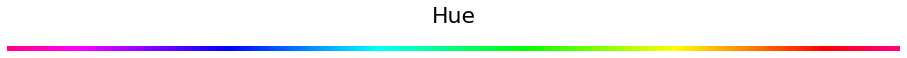

In [108]:
rainbow_rgbs = cv2.cvtColor(np.expand_dims(rainbow_hues, axis=0), cv2.COLOR_HSV2RGB)
plt.matshow(rainbow_rgbs)
plt.axis('off')
plt.title('Hue', fontsize=22)
plt.show()

### Coloured arches

The visualisation of the hue circle does not have a spatial resolution (i.e., only one row),
to better appreciate the categorical colour phenomenon, we convert the hue circle into
an image of coloured arches, similar to natural rainbow.

In [2]:
def create_rainbow_arches():
    img_size = num_hues * 4
    rainbow_image = np.ones((img_size, img_size, 3), dtype='uint8') * 255
    centre = (img_size // 2, img_size // 2)
    
    for hue_ind, hue in enumerate(rainbow_rgbs.squeeze()):
        radius = hue_ind + 2 + 170
        rainbow_image = cv2.ellipse(rainbow_image, centre, (radius, radius), 0, 180, 360, hue.tolist(), thickness=2)
    # only the bottom part of image has content (they're half circles)
    rainbow_image = rainbow_image[0:centre[0]]
    return rainbow_image

When we illustrate coloured arches, we can clearly see colour categories such as
(from bottom to top):
1. pink
2. purple
3. blue
4. cyan
5. green
6. yellow
7. orange
8. red

Although to different observers the actual colour names and the number of distinct
colour categories might differ, but the principle remains the same, everyone sees
the continuous function in discrete categories.

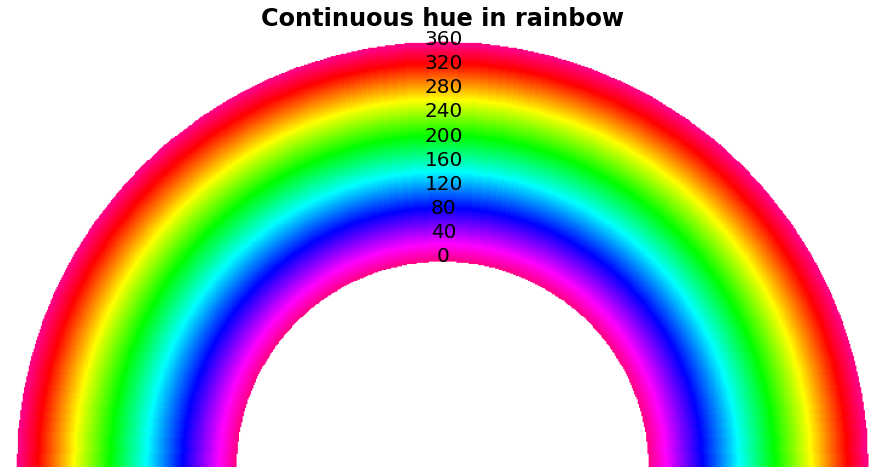

In [24]:
rainbow_image = create_rainbow_arches()

fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(rainbow_image)
ax.axis('off')

# adding the hue axis
for deg in range(0, 181, 20):
    xoffset = len(str(deg*2)) * 5
    ax.text(rainbow_image.shape[1] // 2 - xoffset, 190-deg, deg*2, fontsize=20)
ax.set_title('Continuous hue in rainbow', fontsize=24, fontweight='bold')
fig.savefig('../presentations/DeepReconciliationOfCategoricalColourPerception/rainbow.svg')

### Open questions

This is a fascinating phenomenon that raises the following questions:
1. Why do we perceive a continuous function in different categories?
2. Are these categories shared among everyone or are there significant
   individual differences?
3. Is the categorical colour perception because of linguistic terms we
   assign to colours and/or this is purely driven by our visual system?

In this project, we used deep neural networks as a framework to study some
aspects of categorical colour perception:
1. We compare **multimodal vision-language** to **unimodal vision** deep
   neural networks to investigate **the role of language**.
2. We compare 24 networks pretrained on an identical dataset for 24 distinct
   tasks to investigate **the role of visual tasks**.
3. We compare two **convolutional neural networks (CNN)** to **vision
   transformers (ViT)** to investigate **the role of architecture**.
4. We compare representation at different **intermediate layers** to investigate
   whether this is **low-, mid, or high-level** representation.

## Stimuli

In this section we describe the stimuli set we used to evaluate networks.

### Munsell chips

We use 320 *Munsell chips* to evaluate our networks. These chips have been extensively
used in the literature of categorical colour perception.

In [8]:
wcs_info = wcs_data()

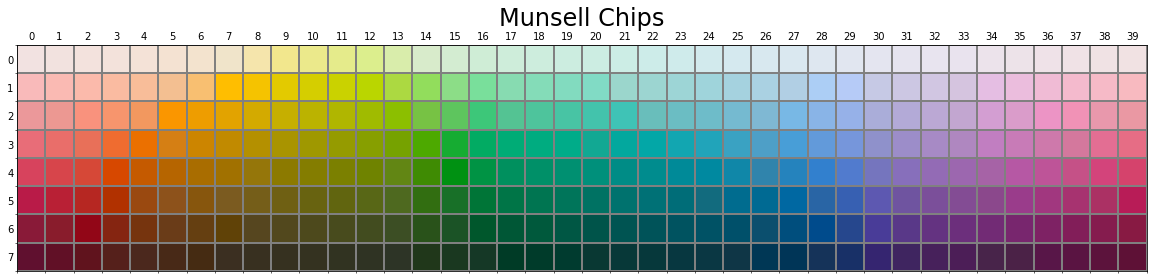

In [10]:
fig = plot_with_grid(wcs_info['munsell_chips'], title='Munsell Chips')
fig.savefig('../presentations/DeepReconciliationOfCategoricalColourPerception/munsell_chips.svg')

### Human data

We rely on human-data for **8** chromatic colour categories *(Berlin & Kay, 1969; Sturges & Whitfield, 1995)*.

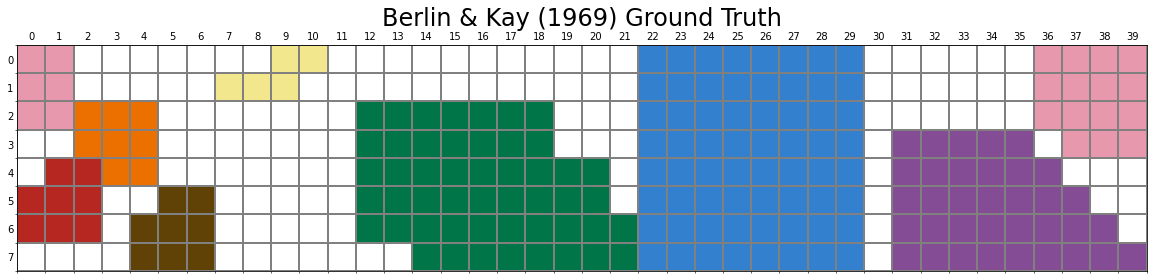

In [12]:
fig = plot_with_grid(colour_label(wcs_info['gts']['berlin'], wcs_info['focal_colours']['rgb']), 
                     title='Berlin & Kay (1969) Ground Truth')
fig.savefig('../presentations/DeepReconciliationOfCategoricalColourPerception/berin_gt.png')

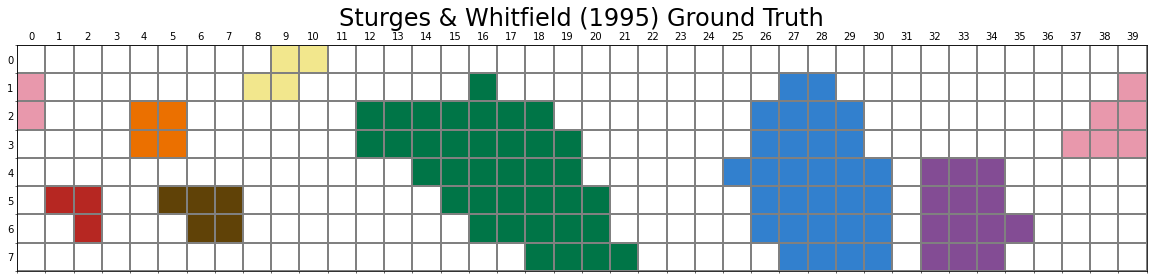

In [13]:
fig = plot_with_grid(colour_label(wcs_info['gts']['sturges'], wcs_info['focal_colours']['rgb']), 
                     title='Sturges & Whitfield (1995) Ground Truth')
fig.savefig('../presentations/DeepReconciliationOfCategoricalColourPerception/sturges_gt.png')

### Shapes

We generated 2905 shapes by systematically changing five parameters of
superellipse equation:

$
r = \left( |\frac{cos(\theta)}{a}|^{n} + |\frac{sin(\theta)}{b}|^{n} \right)^{\frac{-1}{n}}
$

The idea behind using a systematic geometrical shape is to investigate the interaction
between object shape and colour perception. This is beyond the scope of this notebook
and is part of another project.

We can plot 25 of those superellipses randomly.

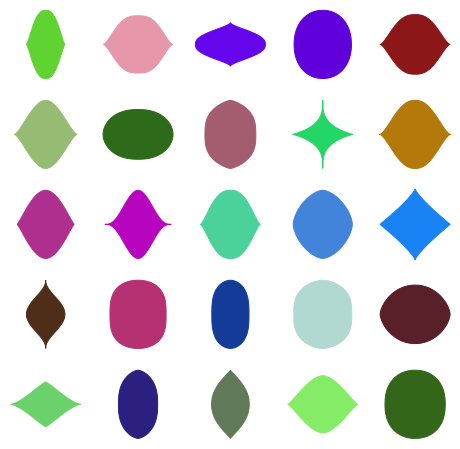

In [61]:
fig = plt.figure(figsize=(8, 8))
for i in range(25):
    a, b = np.random.uniform(0.5, 1), np.random.uniform(0.5, 1)
    m, n = np.random.uniform(0.3, 3), np.random.uniform(0.3, 3)
    xys = np.array(
        [superellipse(a, b, m, n, phi) for phi in np.arange(0, 2 * np.pi, 0.01)]
    )
    ax = fig.add_subplot(5, 5, i+1)
    ax.fill(xys[:, 0], xys[:, 1], color=np.random.uniform(0, 1, (1, 3)))
    ax.axis('equal')
    ax.axis('off')

## Experiments

### Language models: zero-shot evaluation

For the language models (i.e., **CLIP**) we can directly conduct psychophysics
on the network without any intermediate step:
* For each shape, we colour it with a Munsell chip and input the network
  with eight phrases corresponding to eight colour terms.
* The phrase: **"This is a {COLOUR-TERM} shape."** and *COLOUR-TERM* is one of
  these terms: **red, orange, yellow, brown, green, blue, purple, pink**.
* Network's output is a number (the probability of the phrase matching the image).
  We take the phrase with the highest probability as the network's final output.
* For each Munsell chip, we repeat this procedure for all shapes (2905),
  performing **23,240 trials** ($8\times 2905$).

Let's look at one example with simulated data. In this example, the network's output
is highest for the phrase **"This is a red shape."**, therefore we take that as
the network has placed this colour into the red category. The average across all 2905
shapes would be the final prediction of the network for this colour.

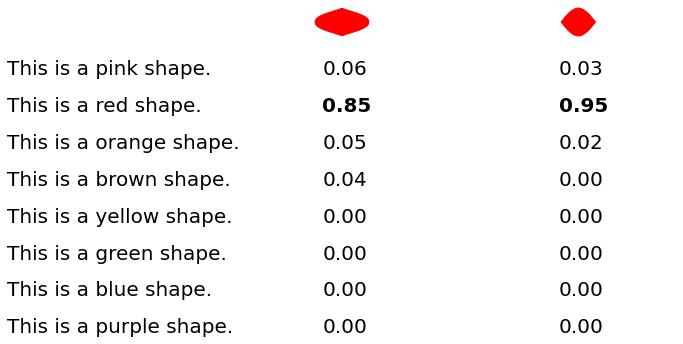

In [14]:
fig = plt.figure(figsize=(12, 6))

for shape_ind in range(2):
    a, b = np.random.uniform(0.5, 1), np.random.uniform(0.5, 1)
    m, n = np.random.uniform(0.3, 3), np.random.uniform(0.3, 3)
    xys = np.array(
        [superellipse(a, b, m, n, phi) for phi in np.arange(0, 2 * np.pi, 0.01)]
    )

    ax = fig.add_subplot(9, 3, 2+shape_ind)
    ax.fill(xys[:, 0], xys[:, 1], color=[1, 0, 0])
    ax.axis('equal')
    ax.axis('off')

simulated_probs = [
    [0.06, 0.85, 0.05, 0.04, 0, 0, 0, 0],
    [0.03, 0.95, 0.02, 0.00, 0, 0, 0, 0]
]
ax_ind = 3
for i in range(8):
    ax_ind +=1
    ax = fig.add_subplot(9, 3, ax_ind)
    ax.axis('off')
    ax.text(0, 0, "This is a %s shape." % wcs_info['focal_colours']['label'][i], fontsize=20)
    ax_ind +=1
    ax = fig.add_subplot(9, 3, ax_ind)
    ax.axis('off')
    ax.text(0.4, 0, "%.2f" % simulated_probs[0][i], fontsize=20, fontweight='bold' if i == 1 else None)
    ax_ind +=1
    ax = fig.add_subplot(9, 3, ax_ind)
    ax.axis('off')
    ax.text(0.4, 0, "%.2f" % simulated_probs[1][i], fontsize=20, fontweight='bold' if i == 1 else None)
fig.savefig('../presentations/DeepReconciliationOfCategoricalColourPerception/zero_shot.svg')

### Vision models: odd-one-out linear classifier

It is impossible to directly ask a neural network trained on a task like object 
recognition about colour categories, as the neural network was specifically 
trained for another task. To overcome this, we trained a linear classifier to 
perform a 4AFC colour discrimination task and at test time evaluate whether
this discrimination is categorical. That is to say, the framework to evaluate 
the categorical colour perception in vision models consists of two steps:
1. A network is trained on an arbitrary visual task (e.g., object recognition).
   We refer to such a network as a **pretrained network**.
2. Features extracted from the **frozen** pretrained network are input to a linear
   classifier trained for the colour discrimination 4AFC task. We refer to
   the trained linear classifier as a **colour-discriminator**.

#### Training colour-discriminator

The figure below shows the schematics of our training process.

<img src="../presentations/DeepReconciliationOfCategoricalColourPerception/colour_discriminator.png">

The process of extracting features (also known as, readouts) from a pretrained 
network can occur at any depth of a network. We extract features from six distinct
layers from the early to final layer:
 * Common to all architectures: `fc` for *ImageNet* (classification layer) or `encoder`
   for *Taskonomy* (the final encoding layer) and *CLIP* (the final vision layer).
 * In the case of `ResNet50` architecture, from 5 intermediate areas (a collection
   of residual blocks).
 * In the case of `ViT-B32` from blocks `[1, 4, 7, 10, 11]`.

#### Train images

During the training, the linear classifier is input with four images:
 * Three of those are identical.
 * One odd image that only differs in colour.

The colour difference between common-odd images is drawn from a random uniform
distribution ensuring no colour bias is introduced in the colour discriminator
training.

The background colour is always achromatic whose luminance is drawn from a random
uniform distribution

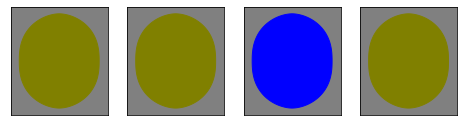

In [53]:
colours = [[0.5, 0.5, 0], [0.5, 0.5, 0], [0.0, 0, 1], [0.5, 0.5, 0]]
plot_random_shape(colours)

#### Testing paradigm

At test time, for each Munsell chip, we evaluate against all sets of focal colour pairs. 
For instance, for the `munsell_chips[3][2]`, we input the network with the following four
colours:
 * The first and last being one focal colour (in this example pink and red categories).
 * The two middle images are identical to the colour of the test chip.

We interpret the results:
1. If the network outputs the pink image as odd, we conclude that the network has put the
   test chip into the **red category**.
2. If the network outputs the red image as odd, we conclude that the network has put the
   test chip in the **pink category**.

We also test the network by swapping the first and last images to ensure the results are
not biased towards a certain index.

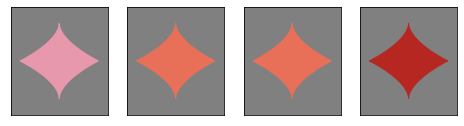

In [54]:
focal_a = np.array(wcs_info['focal_colours']['rgb'][1]).astype('float') / 255
focal_b = np.array(wcs_info['focal_colours']['rgb'][2]).astype('float') / 255
test_chip = np.array(wcs_info['munsell_chips'][3][2]).astype('float') / 255
colours = [focal_a, test_chip, test_chip, focal_b]
plot_random_shape(colours)

For the same test chip, we repeat this procedure for all 28 combinations of pairs of focal colours:

<img src="../presentations/DeepReconciliationOfCategoricalColourPerception/test_paradigm.png">

We assign the colour that wins the most trials across all tests/shapes as the colour of the test
chip.

### Pretrained networks

Architectures:
* **Vision Transformers (ViT)** – *ViT-B32*
* **Convolutional Neural Networks (CNN)** – *ResNet50*

Pretrained task:
* **CLIP**: multimodal text-image matching
* **ImageNet**: unimodal object classification
* **Taskonomy**: 24 unimodal tasks (e.g., scene segmentation, object recognition, edge detection, denoising, etc.).

Inetrmediate layers: six distinct layers corresponding to low-, mid- and high-level visual representation.

In [6]:
arch_areas = {
    'clip_RN50': [*['area%d' % i for i in range(0, 5)], 'encoder'],
    'clip_B32': [*['block%d' % i for i in [1,4,7,10,11]], 'encoder'],
    'resnet50': [*['area%d' % i for i in range(0, 5)], 'fc'],
    'vit_b_32': [*['block%d' % i for i in [1,4,7,10,11]], 'fc'],
    'taskonomy': [*['area%d' % i for i in range(0, 5)], 'encoder']
}

## Results

To better understand the data crunch from raw data to plotted figures, we look
at one example.

### Explaining with one example

We will look at the results of *Block-10* of the *ViT-B32* architecture (i.e.,
the image encoder of CLIP). The directory name `bg128_i0` means the linear classifier
(colour discriminator) has been trained with images of grey background ($R=G=B=127$).

The results are loaded into an array of shape `(320, 8, 8)`: essentially the 320
confusion matrices of size $8 \times 8$.

In [9]:
ex_res_dir = '../results/colour_category/superellipse_grid_4afc/clip/clip_B32/bg128_i0/block10/'
ex_all_conf_mats = read_area_res_conf(ex_res_dir)
print('Shape of the result array:', ex_all_conf_mats.shape)

Shape of the result array: (320, 8, 8)


#### One Test chip

We can simply print the confusion matrix for one particular Munsell chip. We do that
for **chip at index 122** which corresponds to the test colour we visualised when explaining
the testing paradigm:

0. Each cell is the percentage of time a focal colour was selected as the odd element (i.e.,
   lost the categorical battle to another focal colour).
2. The diagonal of the matrix is 0.
3. Higher values indicate strong categorical representation (e.g., orange versus all other colours).
   A value close to 0.50 indicates a chance level and no categorical representation.
5. The confusion matrix cannot be reduced to the (upper/lower) triangle. The sum of $C + C^T \leq 1$,
   where $C$ and $C^T$ denote the confusion matrix and its transpose. Their sum is not guaranteed to
   equal 1, as the selected odd index by the network can also be the identical test chip. Small numbers
   for $C + C^T$ indicate the network's representation is not categorical. Overall, it can be
   observed that the $C + C^T$ is quite close to 1.

In [10]:
print(np.around(ex_all_conf_mats[122], decimals=2))

[[0.   0.2  0.1  0.85 0.53 0.99 0.94 0.96]
 [0.8  0.   0.21 1.   0.86 1.   1.   1.  ]
 [0.9  0.78 0.   0.99 0.97 1.   1.   0.99]
 [0.15 0.   0.01 0.   0.16 0.92 0.67 0.67]
 [0.47 0.14 0.02 0.83 0.   0.98 0.96 0.94]
 [0.01 0.   0.   0.08 0.02 0.   0.19 0.13]
 [0.06 0.   0.   0.33 0.04 0.81 0.   0.49]
 [0.04 0.   0.01 0.33 0.06 0.87 0.51 0.  ]]


We compute the *average* winning rate of each focal colour and the highest value is
selected as the colour of the test chip.:
* In this example *orange* wins against other focal colours $95\%$ of the time.
* Note that the *average* column is not a true probability distribution, the sum is not equal
  to 1.
* A value of 0.50 indicates no categorical representation.

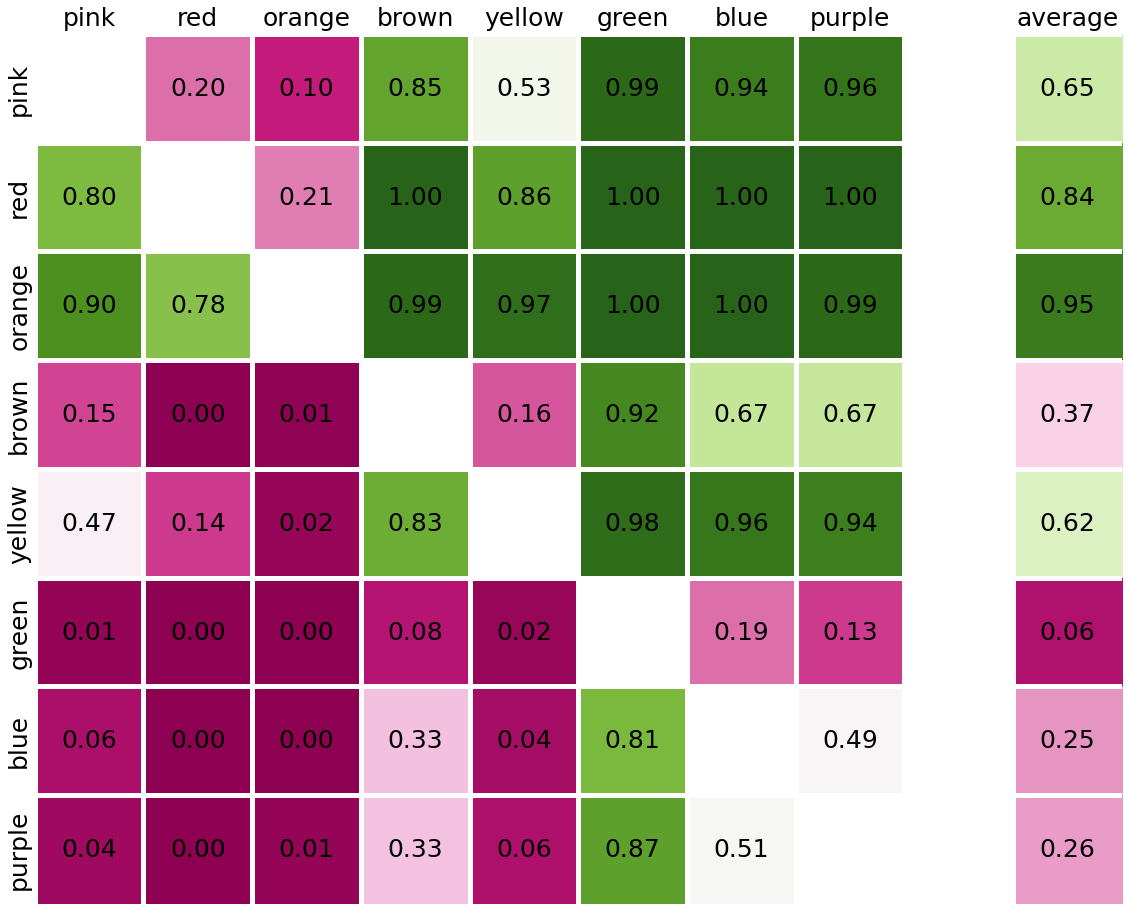

In [219]:
display_labels = wcs_info['focal_colours']['label']
disp, confusion_matrix = plot_conf_mat(ex_all_conf_mats[122], display_labels, cmap='PiYG', precision='%.2f')
disp.figure_.savefig('../presentations/DeepReconciliationOfCategoricalColourPerception/confusion_mat_cat.svg')

#### All chips

We compute the colour of each Munsell chip following the procedure above. We can plot this
in the same format as the original Munsell image.

In [7]:
def final_net_pred(area_res, wcs_info, th=0.5):
    avg_win_rate = area_res.sum(axis=2) / (area_res.shape[1] - 1)
    
    final_cats = avg_win_rate.argmax(axis=1)
    final_cats[wcs_info['gts']['without_gt']] = -1
    final_cats[avg_win_rate.max(axis=1) < th] = -1

    final_cats = final_cats.reshape((8, 40))
    return final_cats

In [22]:
ex_net_pred = final_net_pred(ex_all_conf_mats, wcs_info)

The plotted figure can be interpreted as follows:
* Those cells with a white colour do not have ground truth, therefore excluded.
* Other cells have taken a focal colour according to the network prediction.

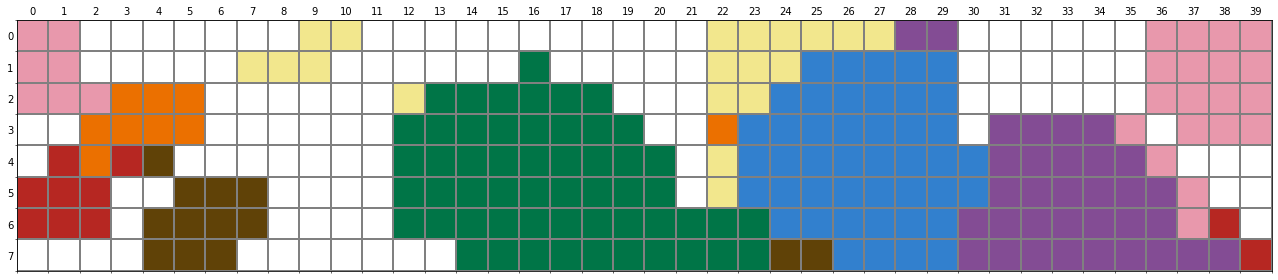

In [41]:
res_img = colour_label(ex_net_pred+1, wcs_info['focal_colours']['rgb'])
fig = plot_with_grid(res_img)

In [7]:
def compare_to_gt(res, gt):
    gt_comp = res != gt
    gt_comp[gt == 0] = 0
    acc = 1-np.sum(gt_comp > 0) / np.sum(gt > 0)
    return gt_comp, acc


def overlay_gt_img(uniquness_class, gt, ax, colours):
    comp_img, acc = compare_to_gt(uniquness_class, gt)
    mis_rows, mis_cols = np.where(comp_img)
    for i in range(len(mis_rows)):
        gt_ind = gt[mis_rows[i], mis_cols[i]]
        color = np.array(colours[gt_ind]) / 255
        ax.plot(mis_cols[i], mis_rows[i], 'x', color=color, markersize=8, alpha=0.75, markeredgewidth=2)
    return ax

We can compute the accuracy with respect to the ground truth. In this example, the network
predicts human data $83\%$ of time.

In [44]:
_, acc_u = compare_to_gt(ex_net_pred+1, wcs_info['gts']['union'])
print('Accuracy to union ground-truth: %.2f' % acc_u)

Accuracy to union ground-truth: 0.83


We plot **x** on top of the cells where the network's prediction mismatch the human data:

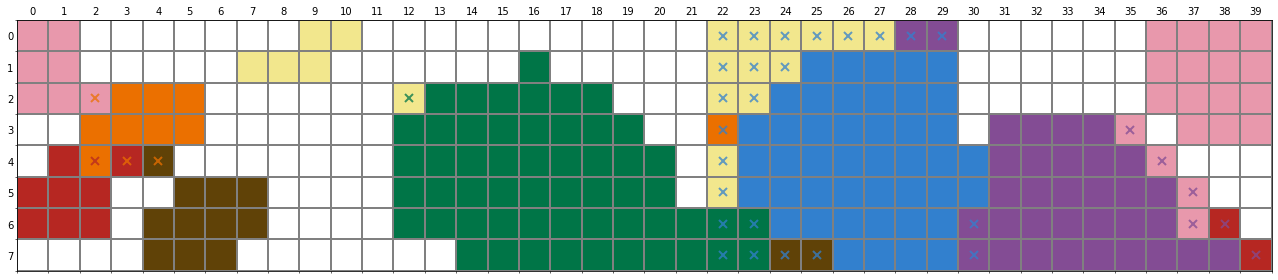

In [45]:
ax = overlay_gt_img(ex_net_pred+1, wcs_info['gts']['union'], fig.axes[0], wcs_info['focal_colours']['rgb'])
fig

### Baseline – RGB Model

To put the obtained results with networks into perspective we compare them to 
the "RGB Model" that assigns the closest colour category (smallest Euclidean 
distance) to a Munsell chip:

 0. Eight focal colours are selected by taking the average of all Munsell chips
    in the Berlin & Kay (1969) and Sturges & Whitfield (1995) Ground Truth.
 1. For each Munsell chip, we compute the Euclidean distance to eight focal colours. 
 2. The focal colour with the smallest Euclidean distance is selected as the
    colour category of that test chip.

In simple words, if the test chip is physically closest in the space to the pink
category, its colour category will be pink.

One might argue that step 0 is not an accurate estimation of focal colours as
the centre of mass does not necessarily determine the focal colour. 
Our rationale behind  this baseline:
 
 * The RGB Model categorises colours uniformly based on proximity.
 * Essentially, in any colour space there is an inherent categorical effect
   of uniform discretisation.
 * Therefore, any categorical effect we observe in the network is significant
   if it surpasses the RGB Model.

We computed the physical proximity in several colour spaces, including:
 * DKL
 * CIE L\*a\*b\*
 * RGB
 * LMS
 * HSV
 * YP<sub>b</sub>P<sub>r</sub>

We have taken RGB as the baseline because of two reasons:
 * The pattern of results across colour spaces is very similar.
 * The input colour space to networks is RGB (i.e., the pretrained datasets are in RGB).
   Therefore we can analyse how much the colour categories alter from the
   input representation to the network's internal representation.

In [14]:
colour_space_res_dir = '../results/colour_category/munsell_vs_wcs_consensus_focal/'

colour_spaces_pred = dict()
for cspace in glob.glob(colour_space_res_dir + '/*.pickle'):
    res = read_pickle(cspace)
    space_name = os.path.basename(cspace).split('.')[0]
    colour_spaces_pred[space_name] = res

### The role of language

To assess the role of language on categorical colour perception, we compare
the results of two sets of networks pretrained on **CLIP** and **ImageNet**:

|   | CLIP (Multimodal language-vision) | ImageNet (Unimodal vision) |
|---|---|---|
| Vision Transformer (ViT) – ViT-B32  |   |   |
| Convolution Neural Network (CNN) – ResNet50 |   |   |

For each of these networks, we have trained several instances to ensure the
reported results are robust. Given the high degree of similarity across
instances, below we visualise the results for instance 1.

In [8]:
def get_language_res(arch, th):
    res_dir = '../results/colour_category/superellipse_grid_activation/clip/'
    lan_res = np.load(
        '%s/%s/language_vision_128.npy' % (res_dir, arch),
        allow_pickle=True
    )[0]
    all_probs = np.array([lan_res[key] for key in lan_res.keys()])
    winners = all_probs.argmax(axis=2)
    winner_probs = np.array([np.count_nonzero(winners == i, axis=0) for i in range(8)]).T
    winner_probs = winner_probs / winners.shape[0]
    return format_pred(winner_probs, wcs_info, th)


def language_accuracy(final_categories, wcs_info, gt):
    _, accuracy = compare_to_gt(final_categories, wcs_info['gts'][gt])
    return accuracy


def colour_space_accuracy(space_pred, th, wcs_info, gt):
    space_cats = space_pred.argmax(axis=2)
    max_vals = space_pred.max(axis=2)
    max_vals /= max_vals.max()
    if th != 0.5:
        space_cats[max_vals < np.quantile(max_vals.flatten(), th)] = -1
    _, space_acc = compare_to_gt(space_cats+1, wcs_info['gts'][gt])
    return space_acc


def format_pred(net_res, wcs_info, th):
    final_cats = net_res.argmax(axis=1)
    final_cats[wcs_info['gts']['without_gt']] = -1
    final_cats[net_res.max(axis=1) < th] = -1
    final_cats = final_cats.reshape((8, 40)) + 1
    return final_cats


def report_munsell_prediction(net_pred, wcs_info, th):
    final_categories = dict()
    for area_name in net_pred.keys():
        area_res = net_pred[area_name]
        final_categories[area_name] = format_pred(area_res, wcs_info, th)
    return final_categories


def areas_accuracy(final_categories, wcs_info, gt):
    accuracies = dict()
    for area_name, area_val in final_categories.items():
        _, accuracies[area_name] = compare_to_gt(area_val, wcs_info['gts'][gt])
    return accuracies


def plot_munsell_prediction(net_pred, wcs_info, th, gt, title, language=None):
    final_categories = report_munsell_prediction(net_pred, wcs_info, th)
    if language is not None:
        final_categories['language'] = language
    accuracies = areas_accuracy(final_categories, wcs_info, gt)
    fig = plt.figure(figsize=(24, 9)) if language is None else plt.figure(figsize=(24, 12))
    axs = fig.subplots(3, 2) if language is None else fig.subplots(4, 2)
    if language is not None:
        fig.delaxes(axs.flat[-1])

    for area_ind, area_name in enumerate(final_categories.keys()):
        ax = axs.flat[area_ind]
        res_img = colour_label(final_categories[area_name], wcs_info['focal_colours']['rgb'])
        ax = plot_with_grid(res_img, ax)
        ax = overlay_gt_img(final_categories[area_name], wcs_info['gts'][gt], ax, 
                            wcs_info['focal_colours']['rgb'])
        ax.set_title('%s [accuracy=%.2f%%]' % (area_name, accuracies[area_name]), fontsize=18)
    fig.suptitle(title, fontsize=24)
    return fig

#### CLIP - ViT-B32

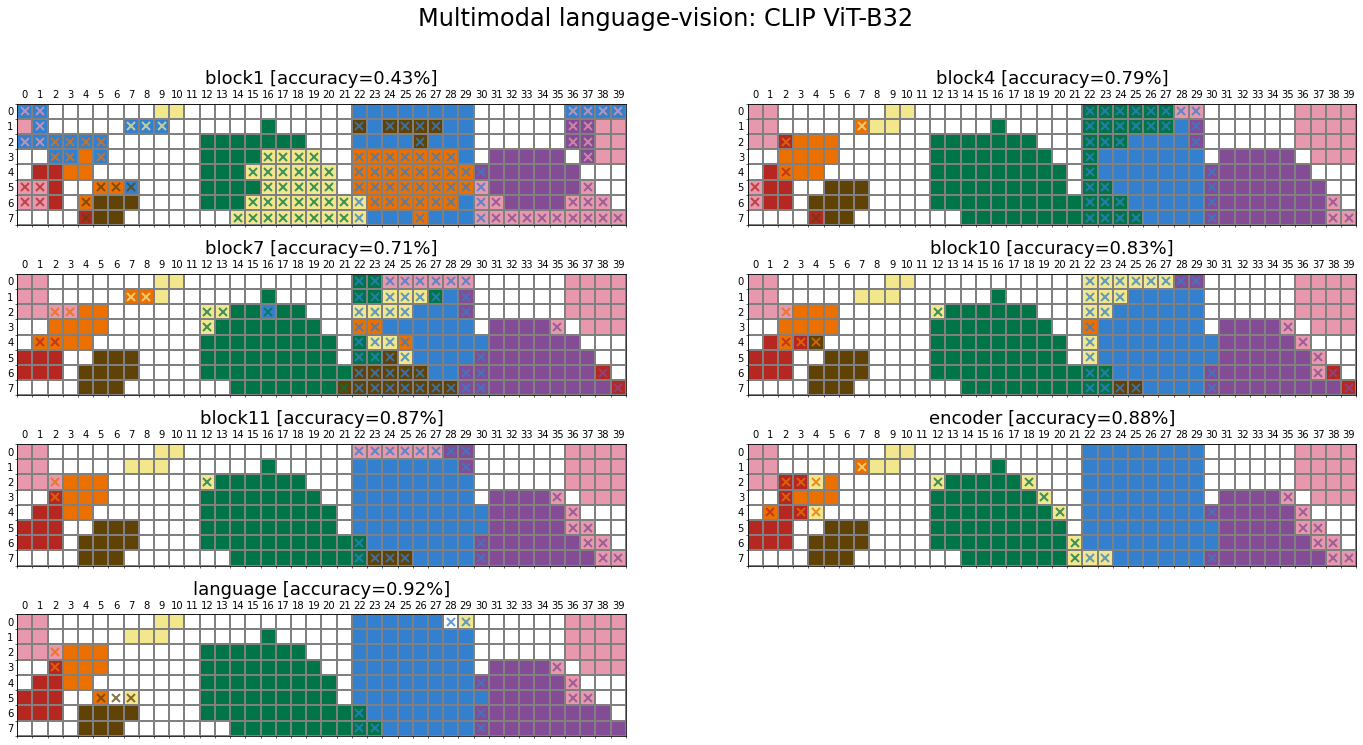

In [59]:
net_res_file = '../analysis/colour_category/superellipse_grid_4afc/clip/clip_B32/bg128_i0.pickle'
net_pred_clip_B32 = read_pickle(net_res_file)
language_res_clip_B32  = get_language_res('clip_B32', 0.5)
fig = plot_munsell_prediction(net_pred_clip_B32, wcs_info, 0.5, 'union', 
                              'Multimodal language-vision: CLIP ViT-B32', 
                              language_res_clip_B32)

#### CLIP - ResNet50

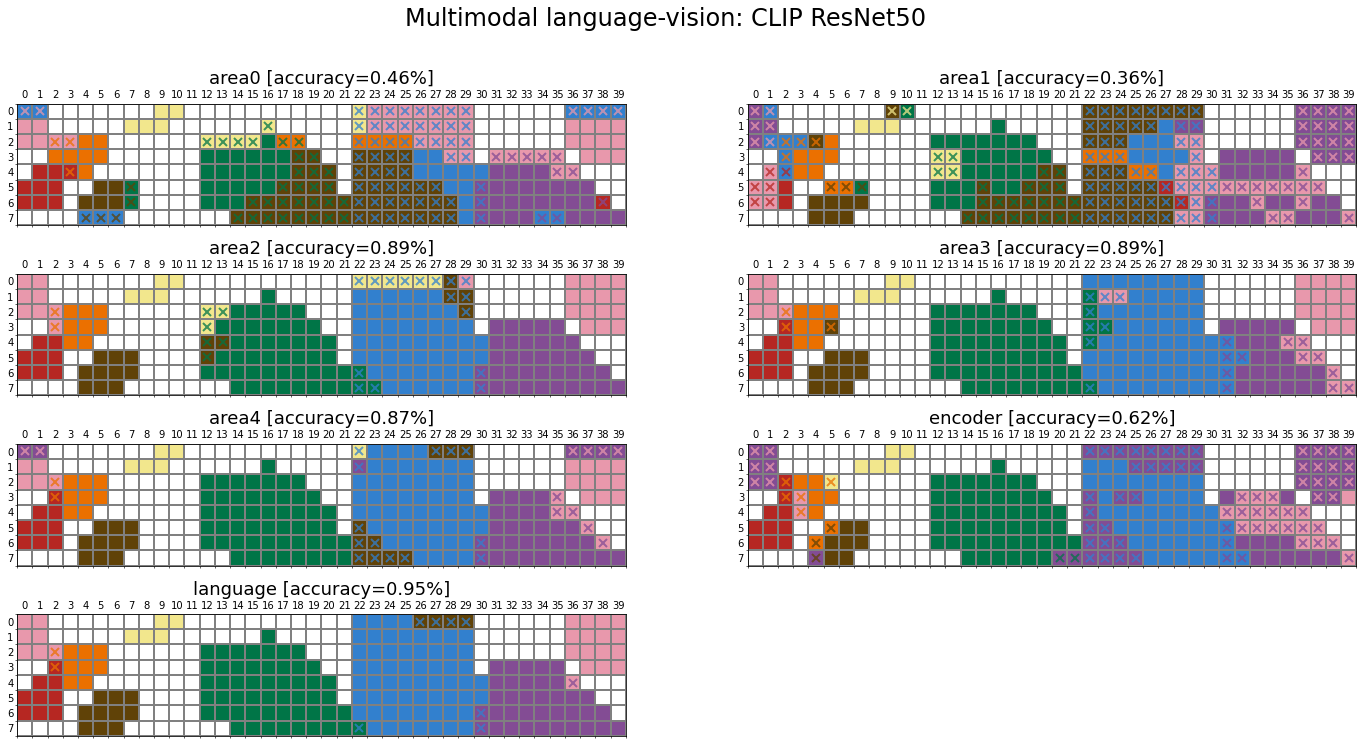

In [60]:
net_res_file = '../analysis/colour_category/superellipse_grid_4afc/clip/clip_RN50/bg128_i0.pickle'
net_pred_clip_RN50 = read_pickle(net_res_file)
language_res_clip_RN50  = get_language_res('clip_RN50', 0.5)
fig = plot_munsell_prediction(net_pred_clip_RN50, wcs_info, 0.5, 'union', 
                              'Multimodal language-vision: CLIP ResNet50', 
                              language_res_clip_RN50)

#### ImageNet - ViT-B32

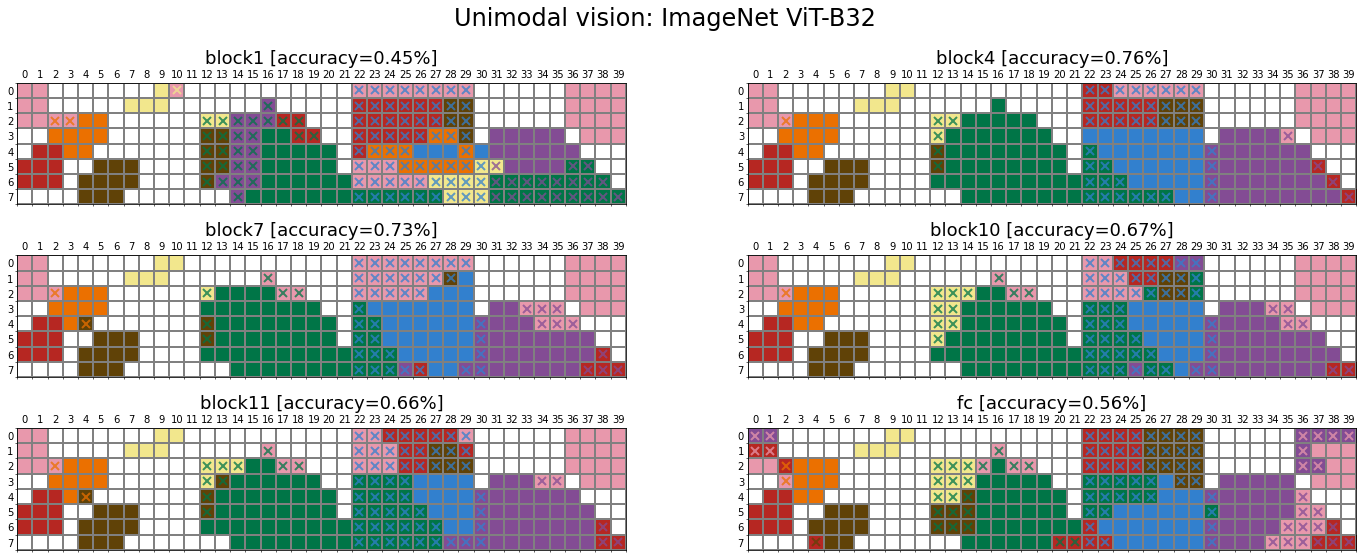

In [61]:
net_res_file = '../analysis/colour_category/superellipse_grid_4afc/imagenet/vit_b_32/bg128_i0.pickle'
net_pred_imagenet_B32 = read_pickle(net_res_file)
fig = plot_munsell_prediction(net_pred_imagenet_B32, wcs_info, 0.5, 'union', 
                              'Unimodal vision: ImageNet ViT-B32')

#### ImageNet - ResNet50

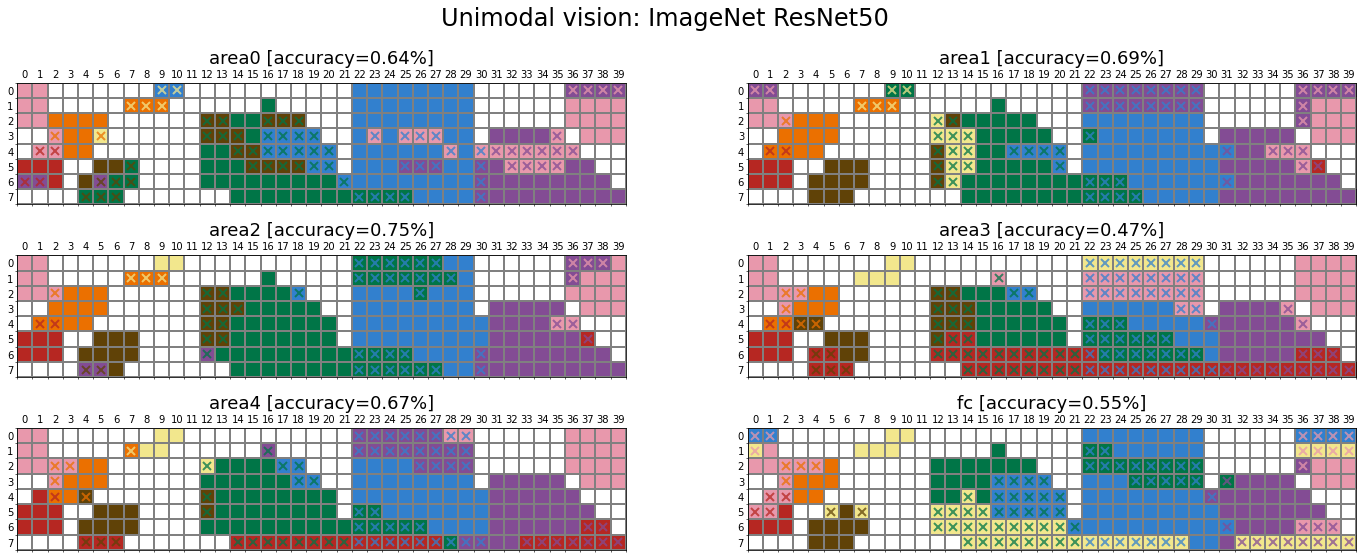

In [62]:
net_res_file = '../analysis/colour_category/superellipse_grid_4afc/imagenet/resnet50//bg128_i0.pickle'
net_pred_imagenet_RN50 = read_pickle(net_res_file)
fig = plot_munsell_prediction(net_pred_imagenet_RN50, wcs_info, 0.5, 'union', 
                              'Unimodal vision: ImageNet ResNet50')

#### Multimodal language-vision vs. Unimodal vision

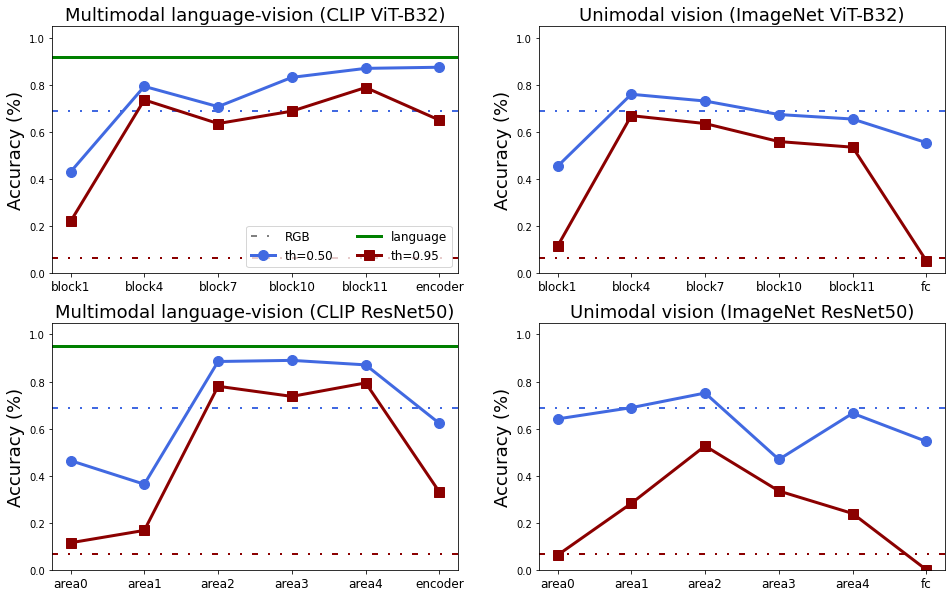

In [63]:
colours_th = ['royalblue', 'darkred']
markers = ['o', 's']
rgb_style=(0, (3, 5, 1, 5, 1, 5))

fig = plt.figure(figsize=(16, 10))
axs = fig.subplots(2, 2)

titles = {
    'clip_B32': 'Multimodal language-vision (CLIP ViT-B32)',
    'clip_RN50': 'Multimodal language-vision (CLIP ResNet50)',
    'vit_b_32': 'Unimodal vision (ImageNet ViT-B32)',
    'resnet50': 'Unimodal vision (ImageNet ResNet50)'
}

gt = 'union'
for th_ind, th in enumerate([0.5, 0.95]):
    clip_vs_imagenet = {
        'clip_B32': areas_accuracy(
            report_munsell_prediction(net_pred_clip_B32, wcs_info, th), wcs_info, gt
        ),
        'vit_b_32': areas_accuracy(
            report_munsell_prediction(net_pred_imagenet_B32, wcs_info, th), wcs_info, gt
        ),
        'clip_RN50': areas_accuracy(
            report_munsell_prediction(net_pred_clip_RN50, wcs_info, th), wcs_info, gt
        ),
        'resnet50': areas_accuracy(
            report_munsell_prediction(net_pred_imagenet_RN50, wcs_info, th), wcs_info, gt
        ),
    }
    for net_ind, (net_type, net_res) in enumerate(clip_vs_imagenet.items()):
        ax = axs.flat[net_ind]
        # rgb model
        rgb_raw = colour_spaces_pred['rgb']
        rgb_acc = colour_space_accuracy(rgb_raw, th, wcs_info, gt)
        if th_ind == 0:
            ax.axhline(rgb_acc, label='RGB', linewidth=2, linestyle=rgb_style, color='Gray')
        ax.axhline(rgb_acc, linewidth=2, linestyle=rgb_style, color=colours_th[th_ind])
        
        ax.plot(list(net_res.values()), '-%s'%markers[th_ind], label='th=%.2f' % th, 
                color=colours_th[th_ind], linewidth=3, markersize=10)
        if 'clip' in net_type and th_ind==0:
            ax.axhline(y=language_accuracy(get_language_res(net_type, th), wcs_info, gt), 
                       label='language', color='green', linewidth=3)
            
        ax.set_ylabel('Accuracy (%)', fontsize=18)
        ax.set_ylim([0, 1.05])
        labels = arch_areas[net_type].copy()
        ax.set_xticks(range(len(labels)), labels, fontsize=12)
        ax.set_title(titles[net_type], fontsize=18)
        if net_ind == 0:
            ax.legend(fontsize=12, ncol=2, loc='lower right')

### The role of visual task

In this section, we examine how the network's task shapes its colour categories using the [Taskonomy dataset](http://taskonomy.stanford.edu/), which contains about four million images (mainly indoor scenes from 2265 different buildings) and their corresponding labels for 25 computer vision tasks. The dataset also provides pretrained networks with an encoder-decoder architecture for all visual tasks. The encoder is the same across all pretrained networks (i.e., ResNet50), which maps the input image ($224 \times 224$) into a latent representation of size 1568 ($14 \times 14 \times 8$). The decoder design varies according to the dimensionality of the task output. The encoder offers a unique opportunity to study the role of visual tasks on the representation a network learns, given its architecture is identical across tasks and has been trained on the same set of images. Similar to ImageNet pretrained networks, we trained a linear classifier on top of the encoder's extracted features from each Taskonomy pretrained network.

In [9]:
task_mapping = {
    'autoencoding': '2D',
    'curvature': '3D',
    'denoising': '2D',
    'edge_texture': '2D',
    'edge_occlusion': '3D',
    'egomotion': 'x3D',
    'fixated_pose': 'x3D',
    'jigsaw': 'x2D',
    'keypoints2d': '2D',
    'keypoints3d': '3D',
    'nonfixated_pose': 'x3D',
    'point_matching': 'x3D',
    'reshading': '3D',
    'depth_zbuffer': '3D',
    'depth_euclidean': '3D',
    'normal': '3D',
    'room_layout': 'geometric',
    'segment_unsup25d': '3D',
    'segment_unsup2d': '2D',
    'segment_semantic': 'semantic',
    'class_object': 'semantic',
    'class_scene': 'semantic',
    'inpainting': '2D',
    'vanishing_point': 'geometric'
}
task_titles = {
    'autoencoding': 'Autoencoding',
    'curvature': '3D Curvature Estimation',
    'denoising': 'Denoising',
    'edge_texture': '2D Edge Detection', 
    'edge_occlusion': '3D Edge Detection',
    'egomotion': 'Egomotion',
    'fixated_pose': 'Camera Pose Estimation (Non-fixated)',
    'jigsaw': 'Jigsaw Puzzle',
    'keypoints2d': '2D Keypoint Detection',
    'keypoints3d': '3D Keypoint Detection',
    'nonfixated_pose': 'Camera Pose Estimation (Non-fixated)',
    'point_matching': 'Point Matching',
    'reshading': 'Reshading',
    'depth_zbuffer': 'Z-Buffer Depth Estimation',
    'depth_euclidean': 'Euclidean Depth Estimation',
    'normal': 'Surface Normal Estimation',
    'room_layout': 'Room Layout',
    'segment_unsup25d': '3D Unsupervised Segmentation',
    'segment_unsup2d': '2D Unsupervised Segmentation',
    'segment_semantic': 'Semantic Segmentation',
    'class_object': 'Object Classification',
    'class_scene': 'Scene Classification',
    'inpainting': 'In-painting',
    'vanishing_point': 'Vanishing Point Estimation'
}
task_colours={
    '2D': [0, 0, 0.8],
    'x2D': [0, 0, 0.8],
    '3D': [0, 0.8, 0],
    'x3D': [0, 0.8, 0],
    'semantic': [204/255, 0, 1],
    'geometric': [1, 0.5, 0.]
}

#### Munsell prediction

/tmp/ipykernel_11056/3151759416.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(24, 9)) if language is None else plt.figure(figsize=(24, 12))


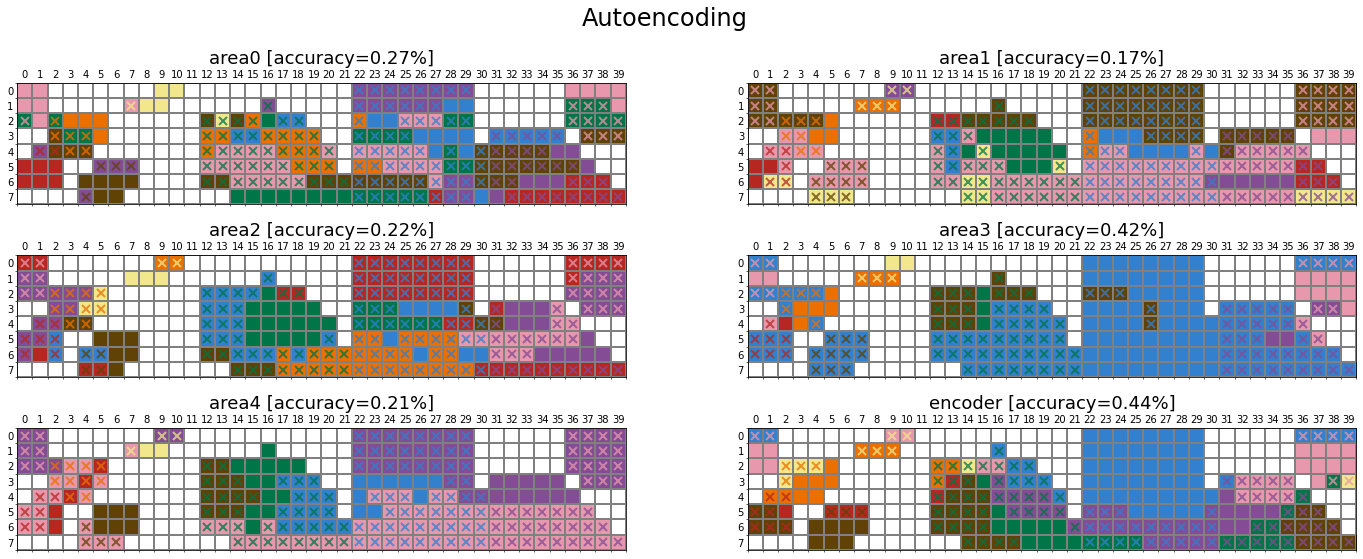

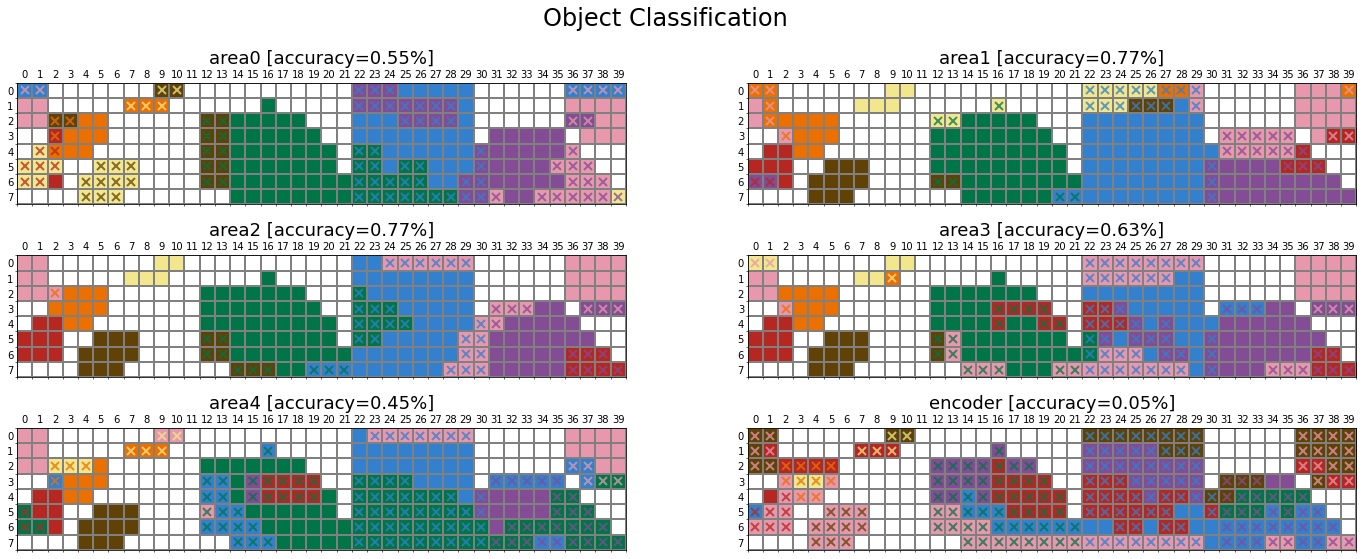

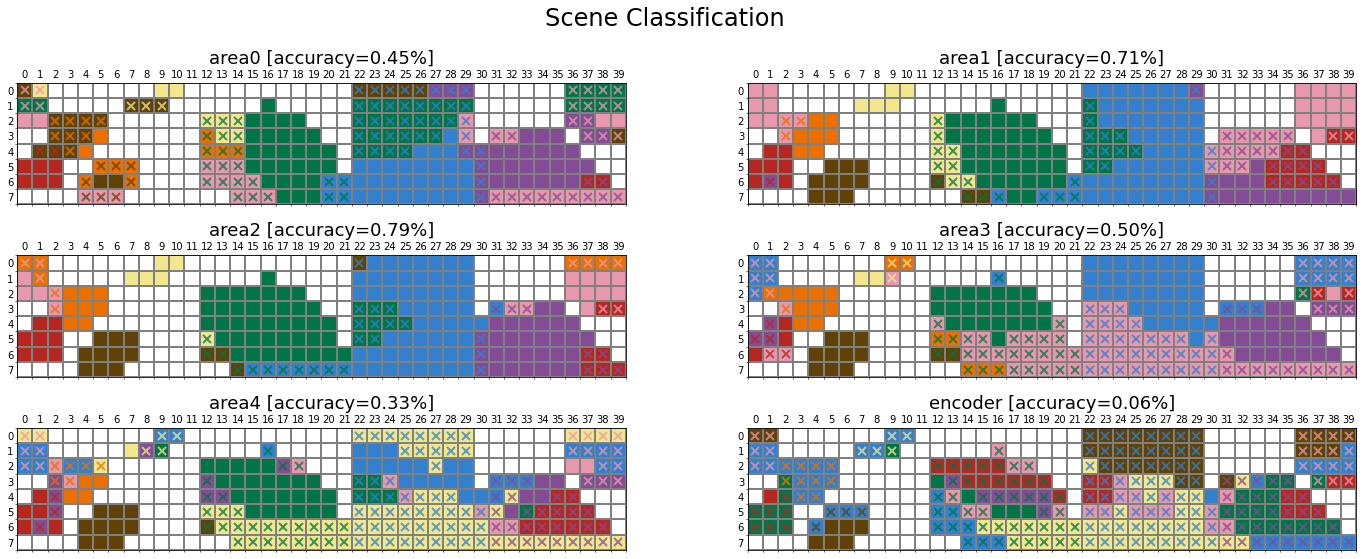

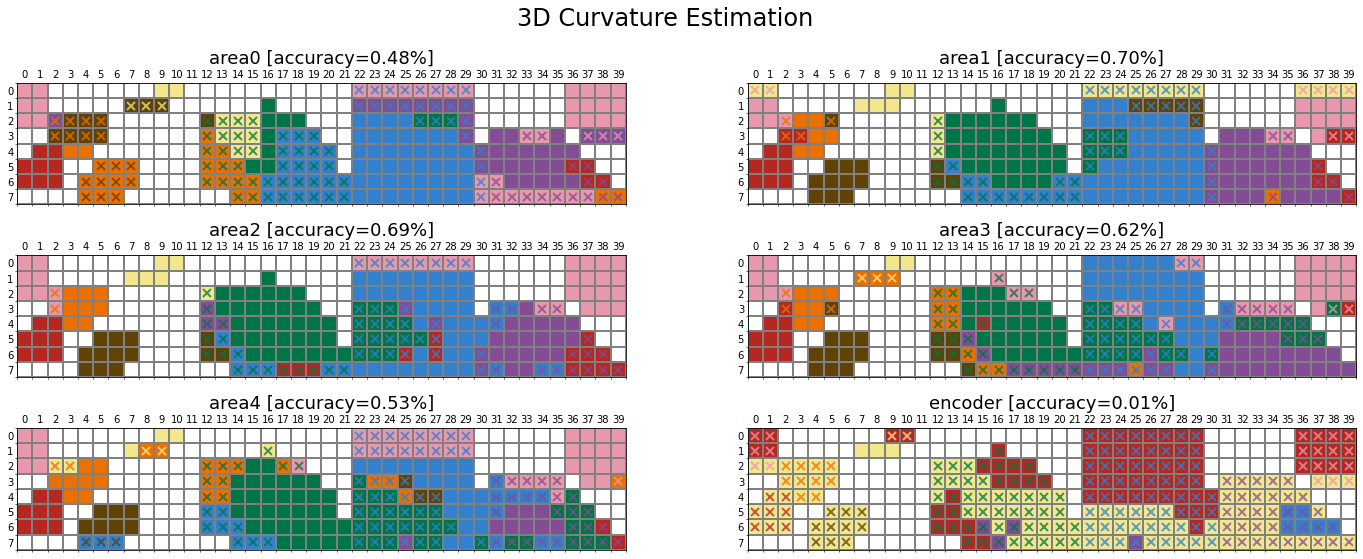

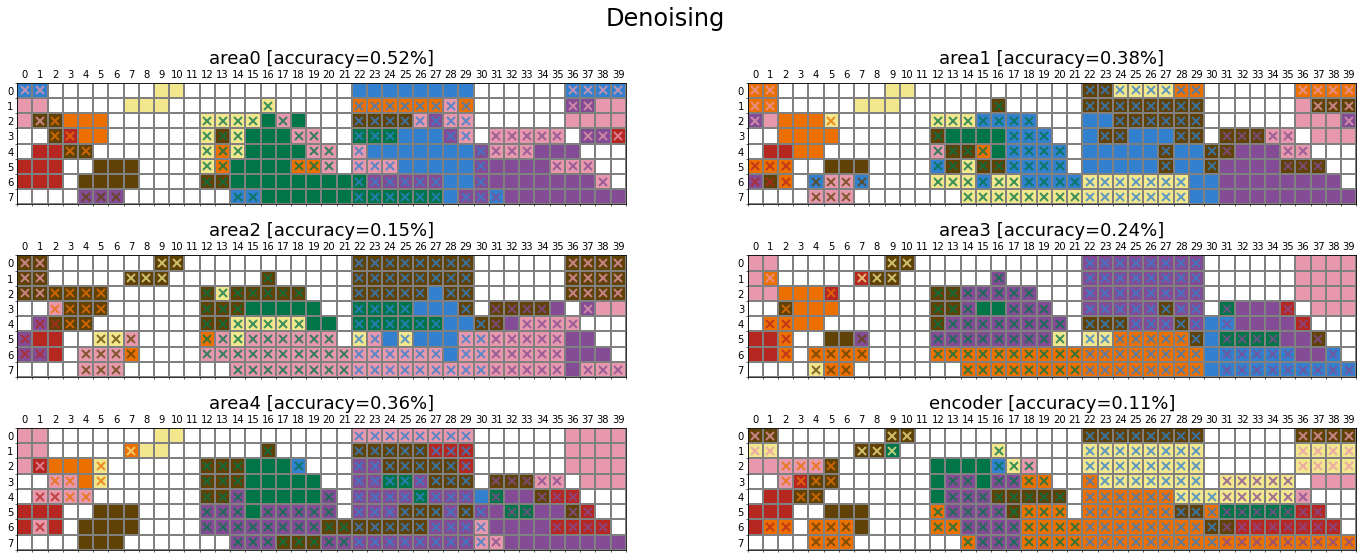

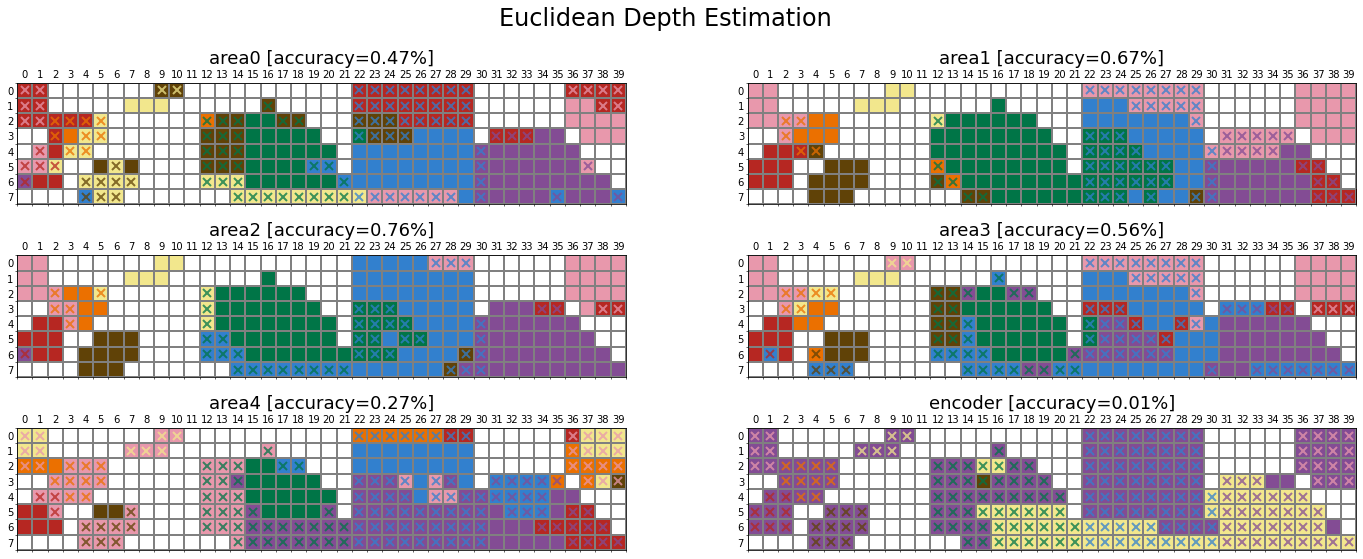

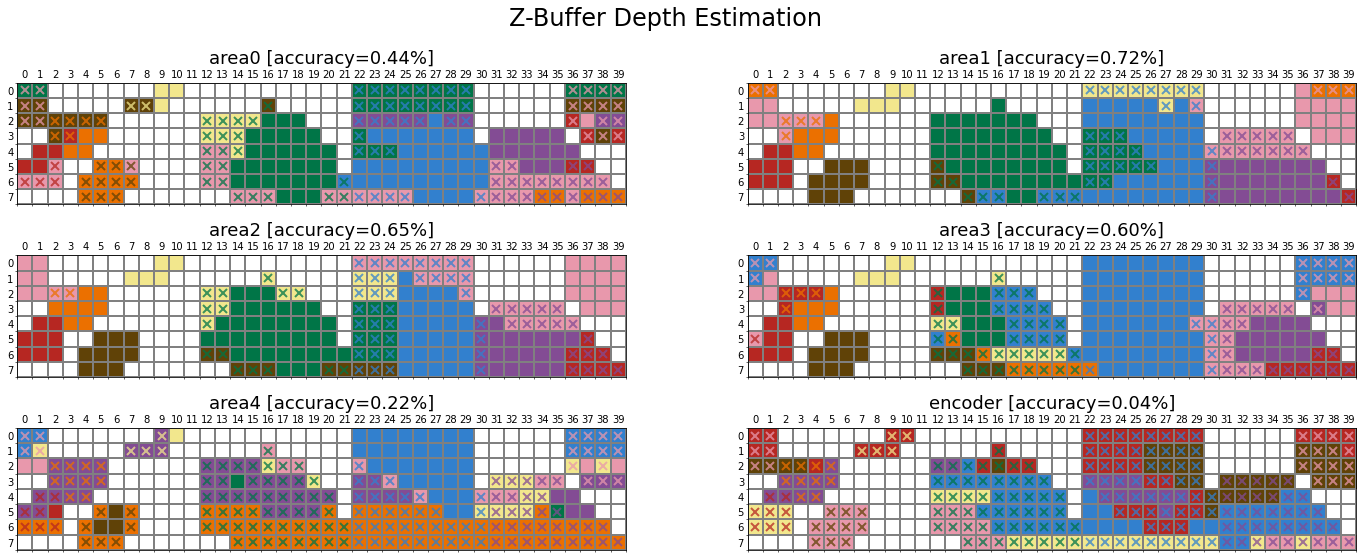

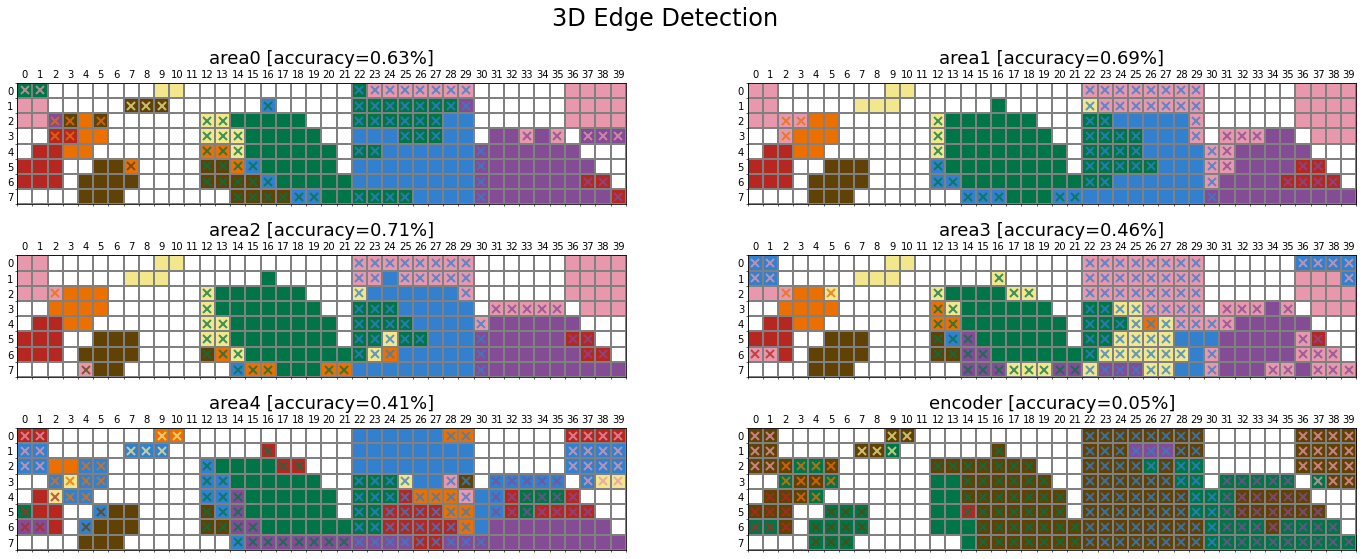

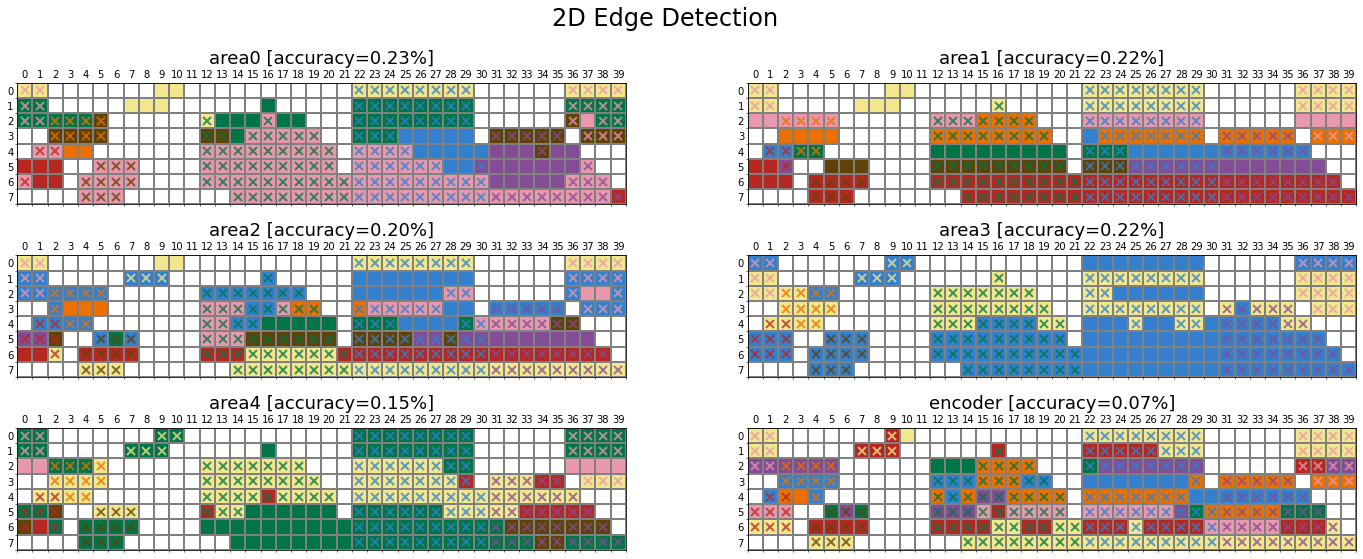

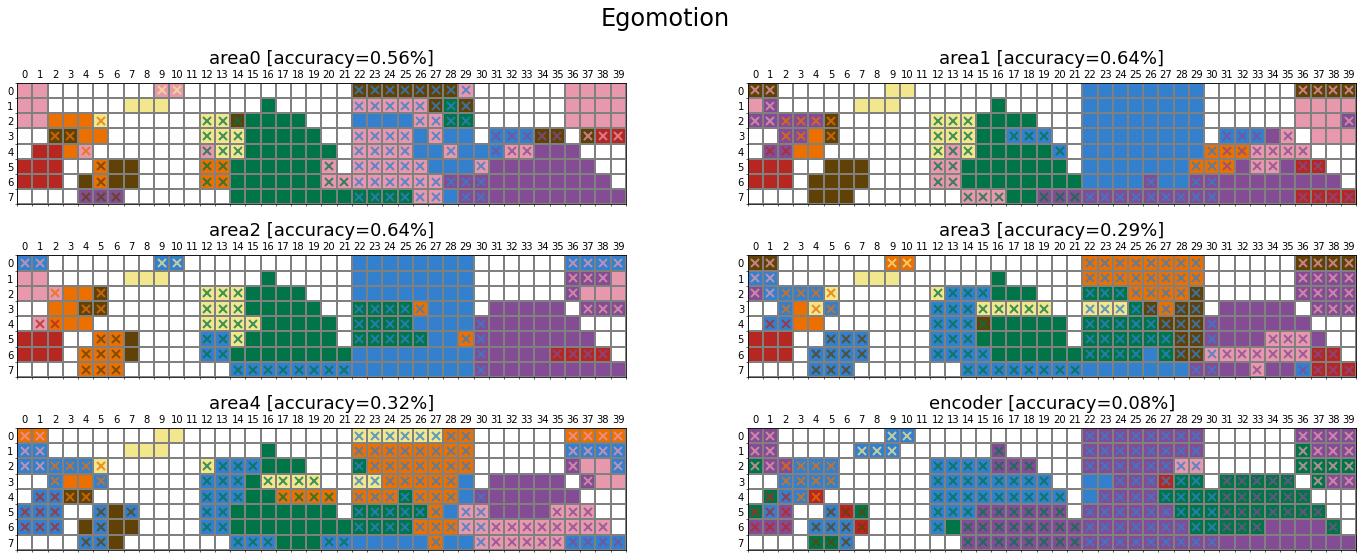

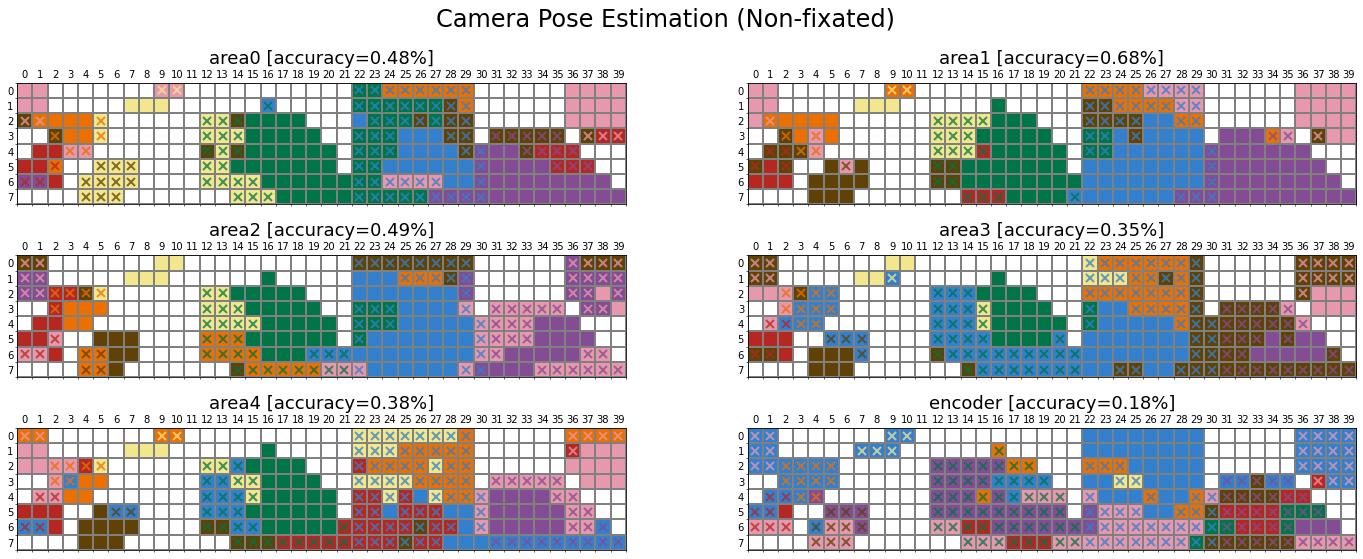

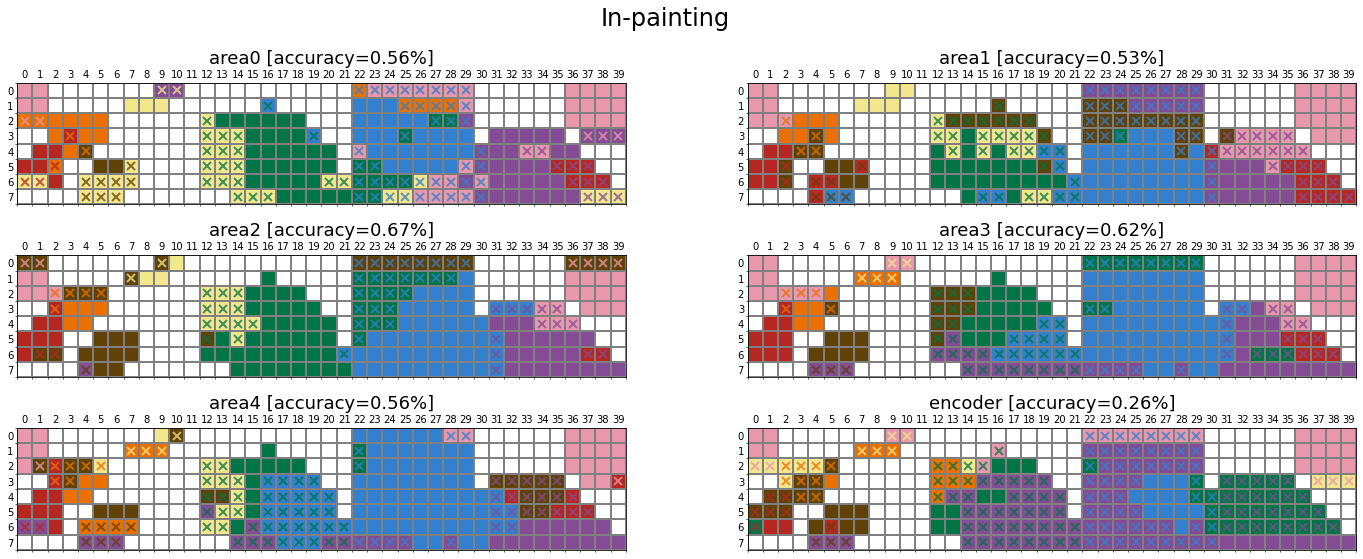

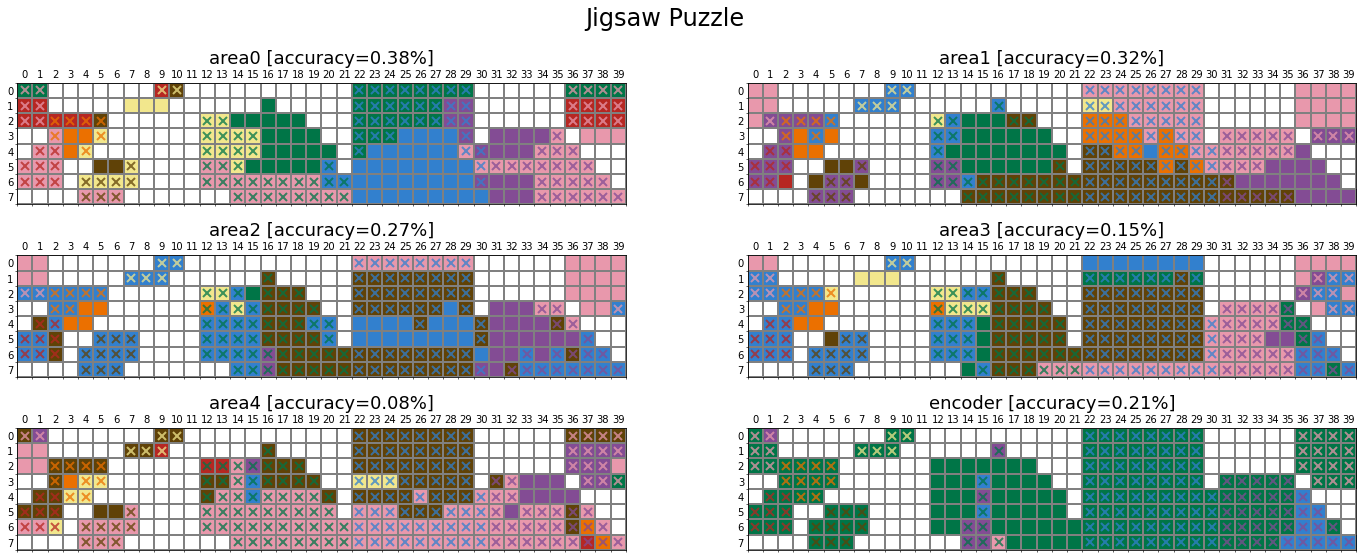

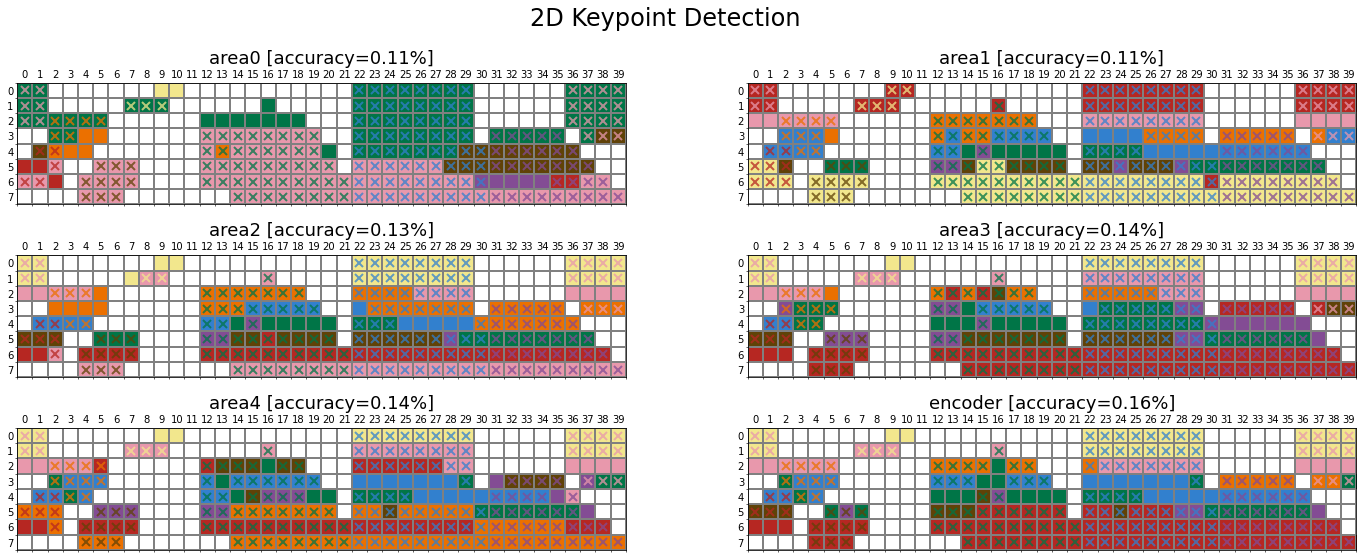

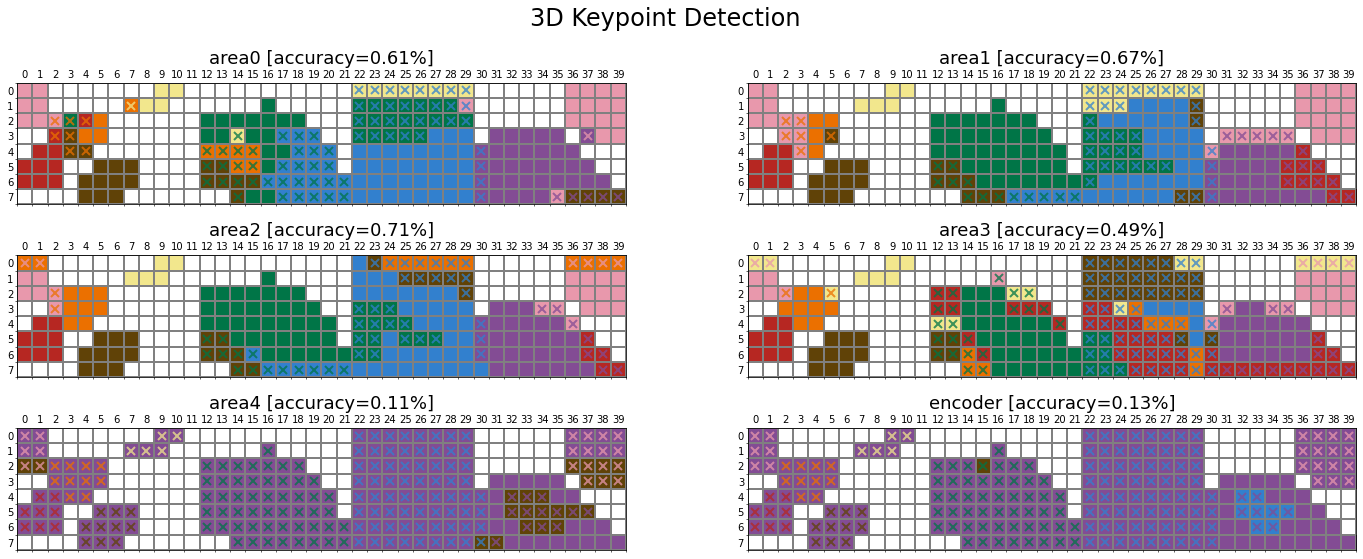

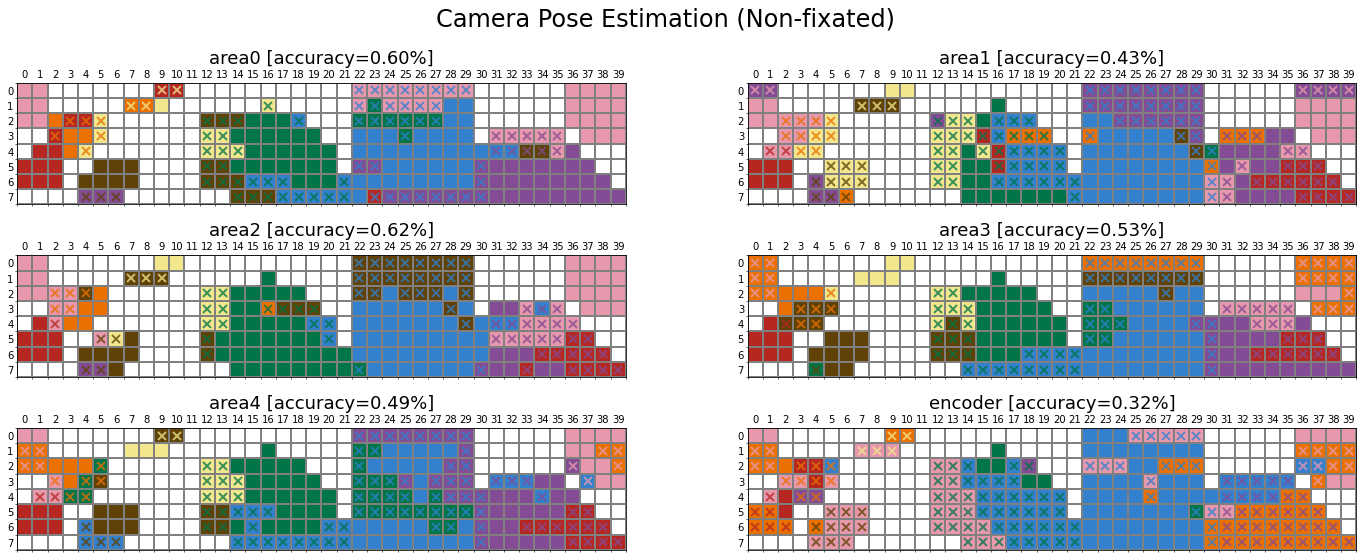

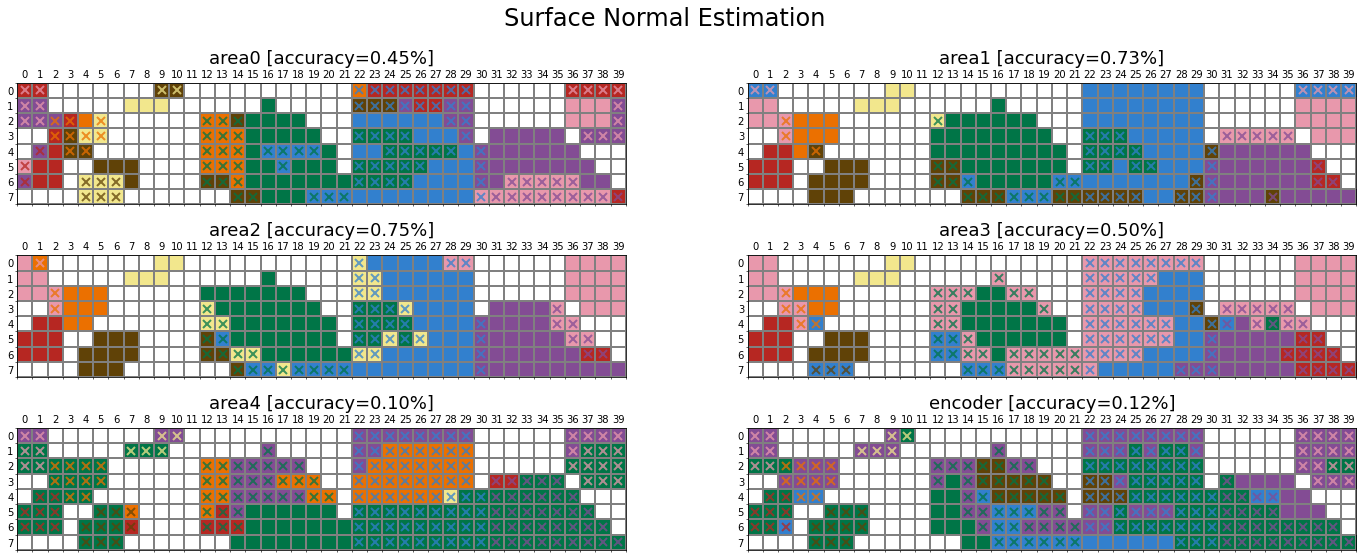

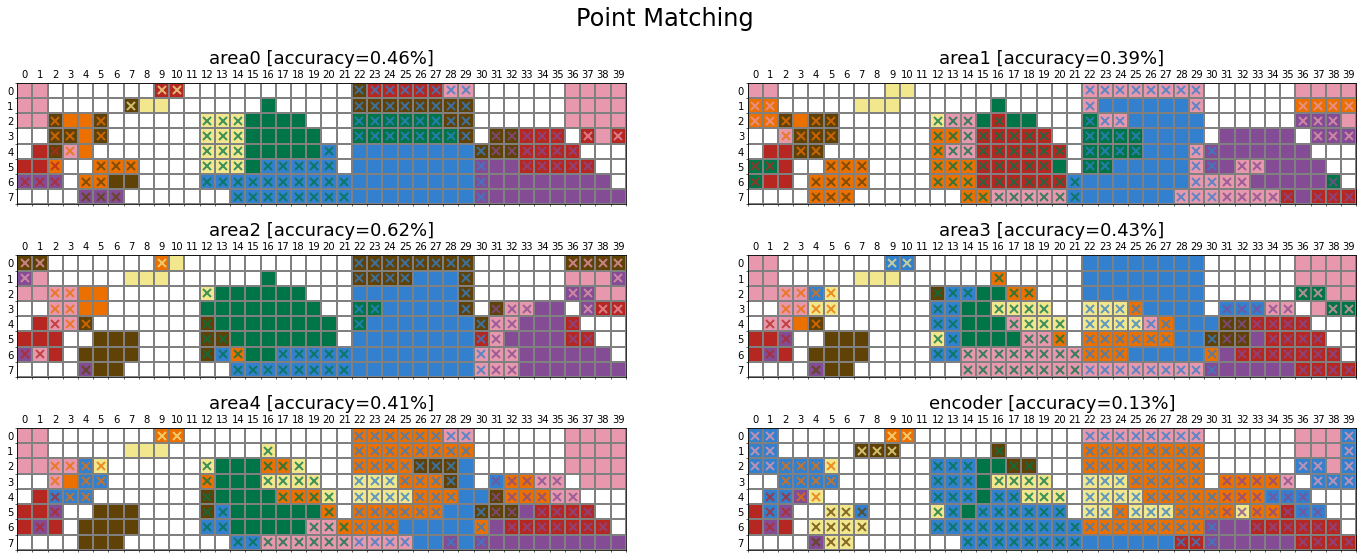

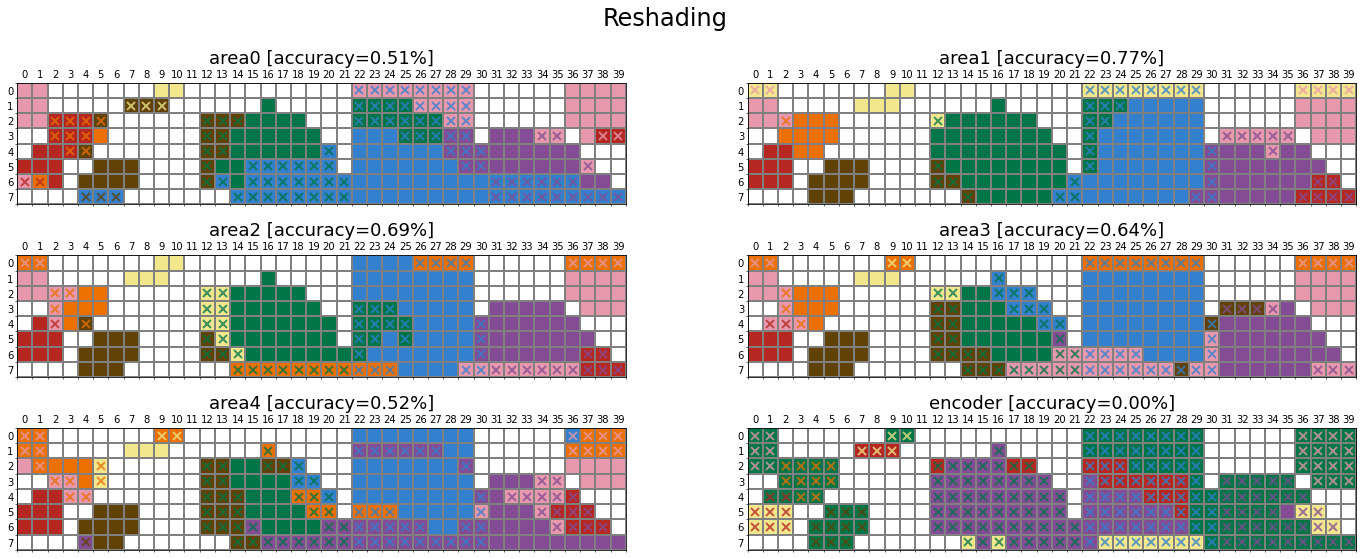

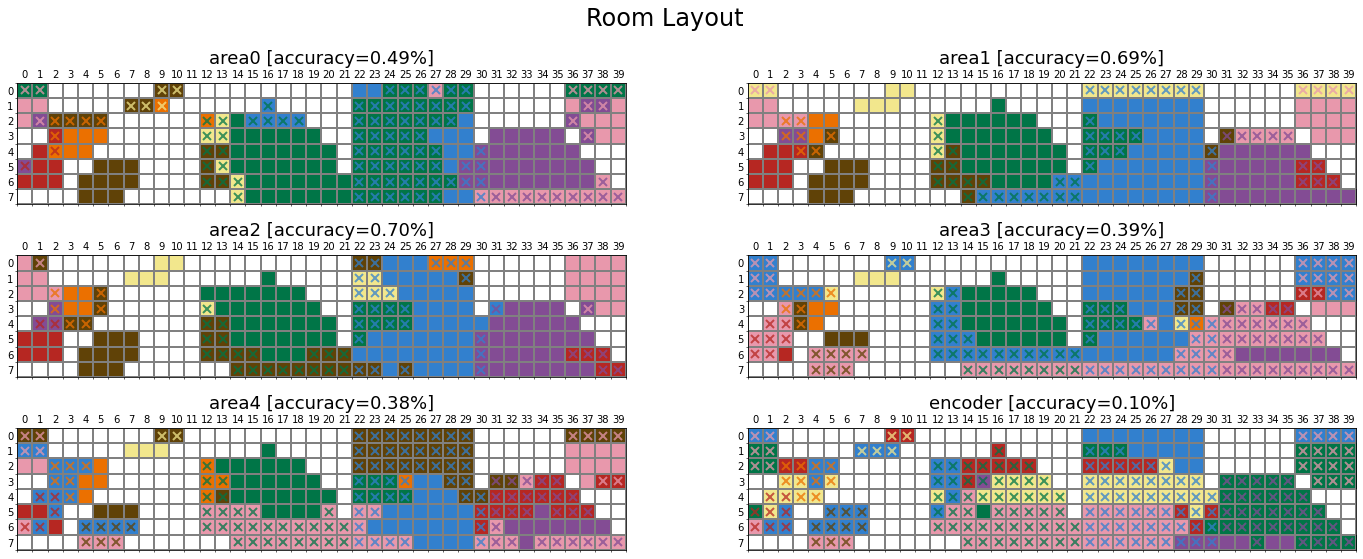

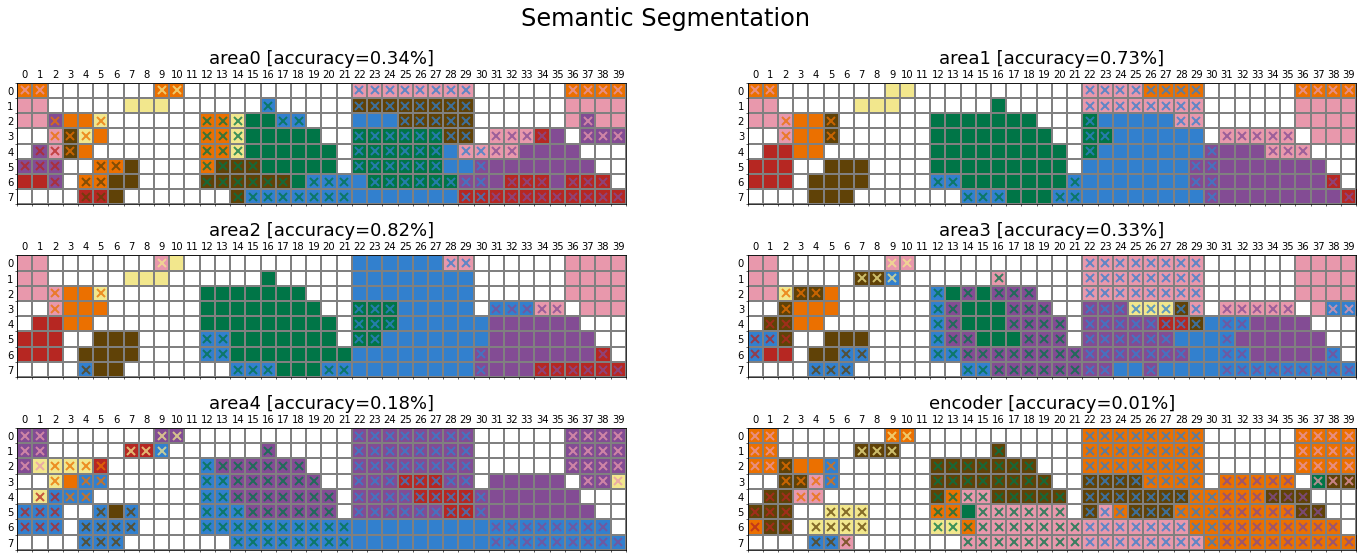

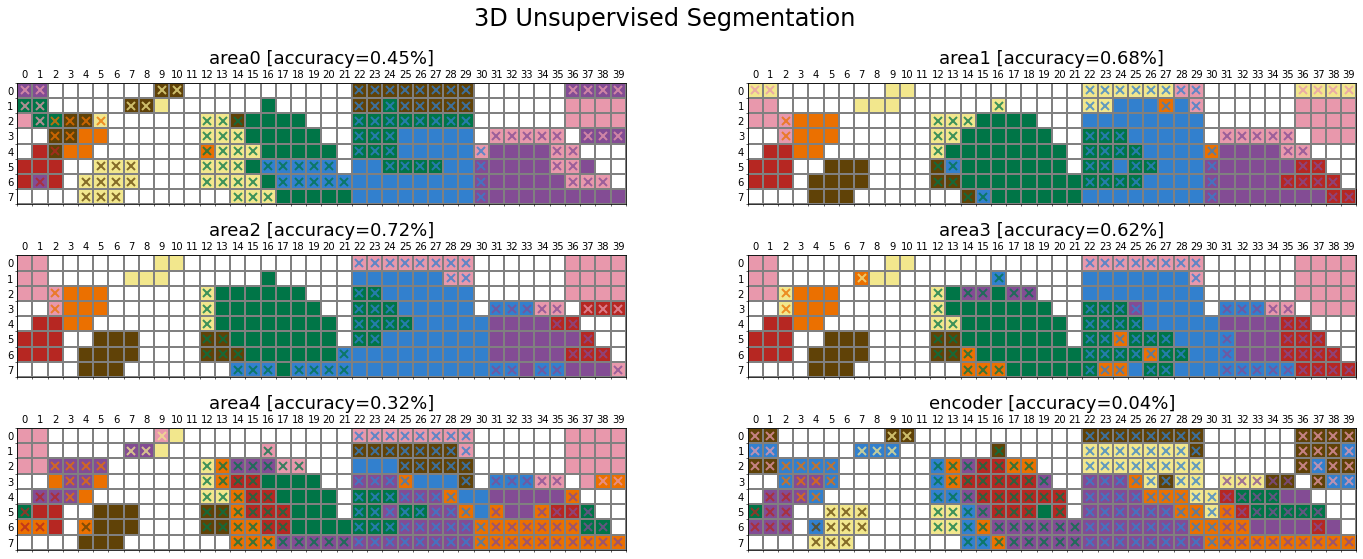

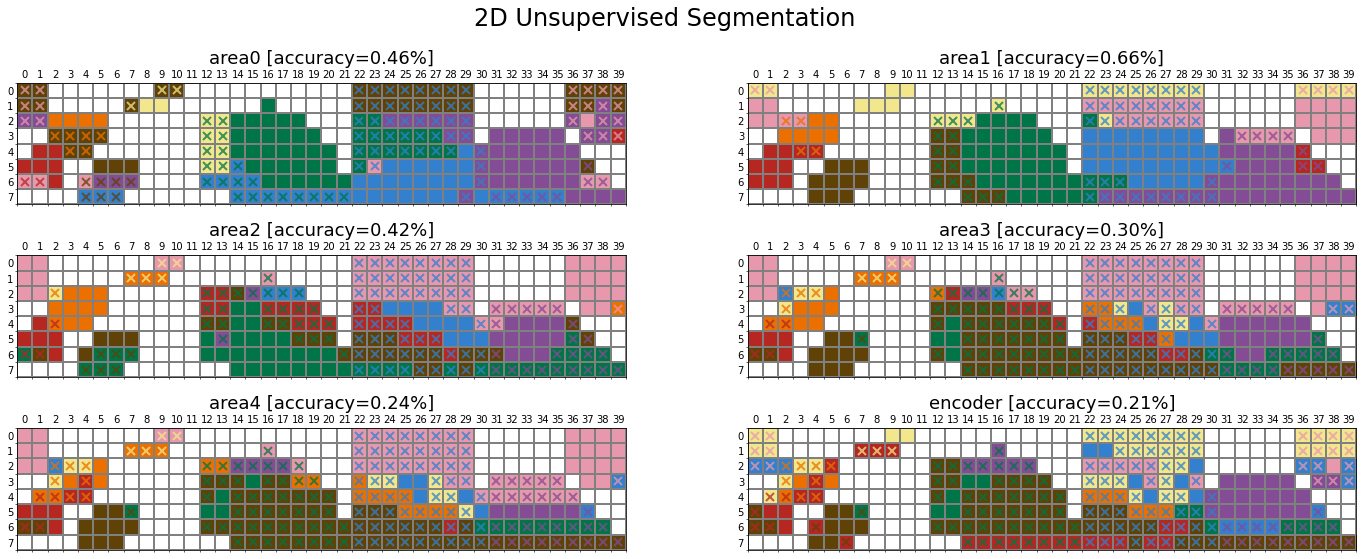

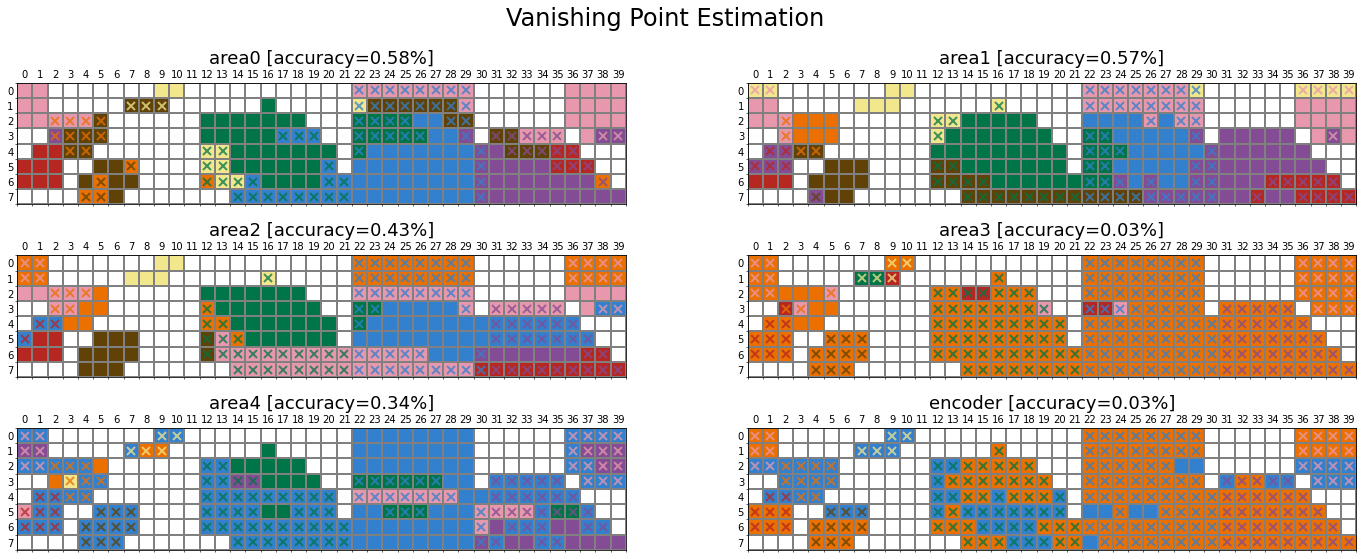

In [250]:
taskonomy_dir = '../analysis/colour_category/superellipse_grid_4afc/taskonomy/'

for task_dir in sorted(glob.glob(taskonomy_dir + '*/')):
    task_name = task_dir.split('/')[-2]
    net_pred = read_pickle('%s/bgnatural_i0.pickle' % (task_dir))
    fig = plot_munsell_prediction(net_pred, wcs_info, 0.5, 'union', task_titles[task_name])

#### Comparison across tasks

In [23]:
taskonomy_dir = '../analysis/colour_category/superellipse_grid_4afc/taskonomy/'

th = 0.5
gt = 'union'
score_type = 'max'
taskonomy_names = []
taskonomy_scores = []
taskonomy_accuracies = dict()
for task_dir in sorted(glob.glob(taskonomy_dir + '*/')):
    task_name = task_dir.split('/')[-2]
    net_pred = read_pickle('%s/bgnatural_i0.pickle' % (task_dir))
    current_accuracies = areas_accuracy(
        report_munsell_prediction(net_pred, wcs_info, th), wcs_info, gt
    )
    taskonomy_accuracies[task_name] = current_accuracies
    taskonomy_scores.append(np.max(list(current_accuracies.values())))
    taskonomy_names.append(task_name)
taskonomy_scores = np.array(taskonomy_scores)
task_orders = np.argsort(taskonomy_scores)

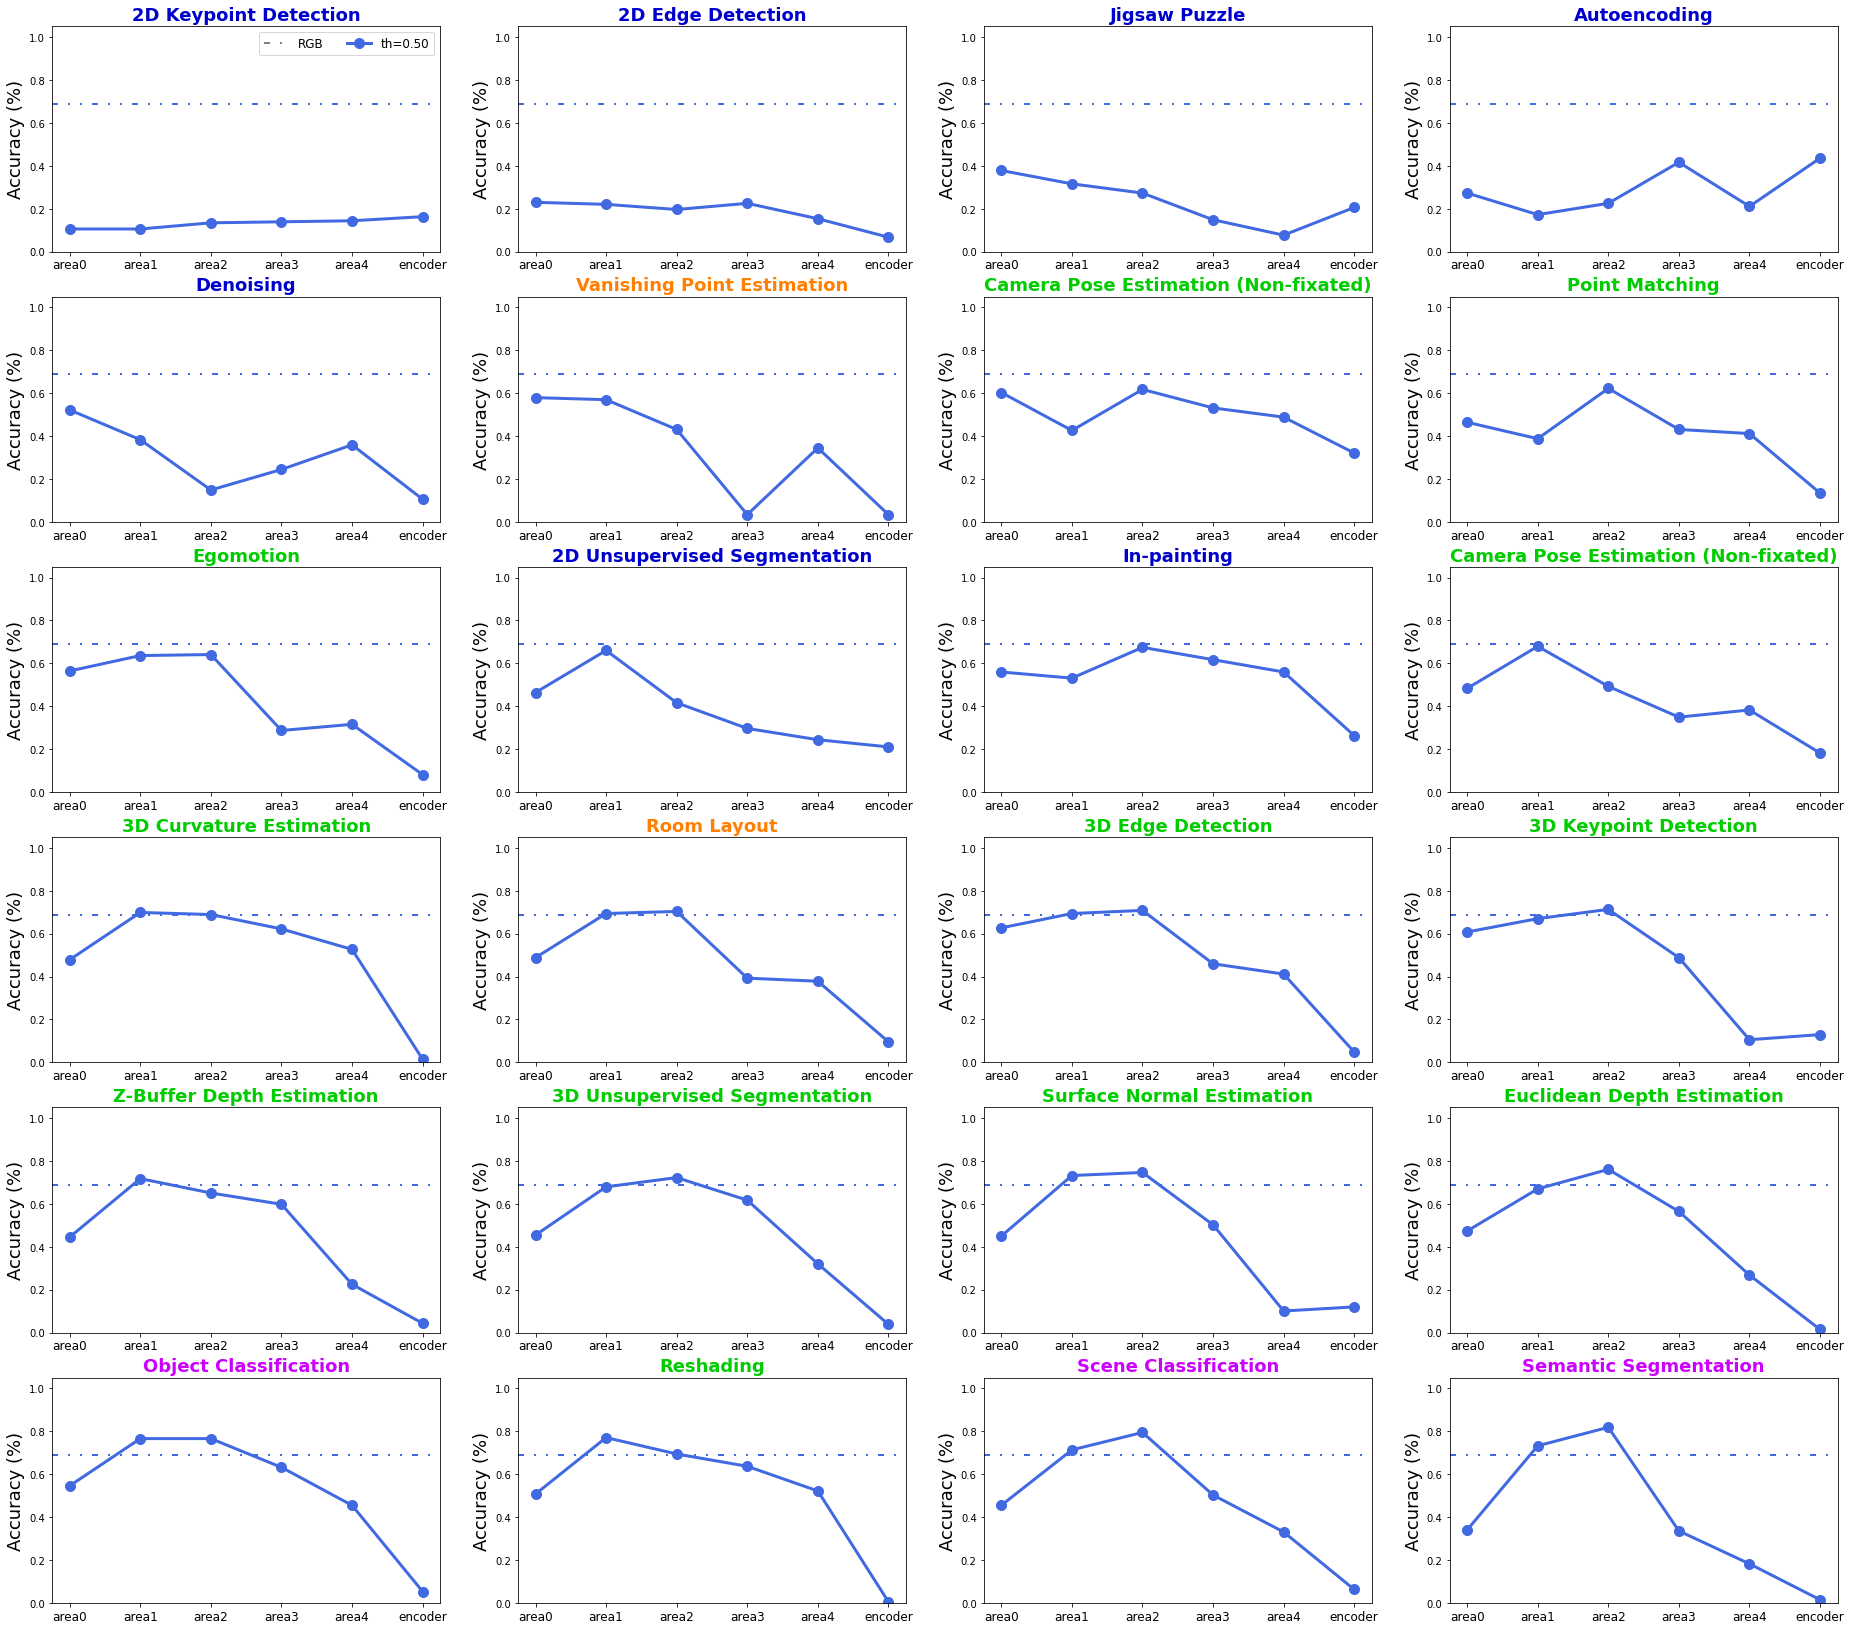

In [17]:
colours_th = ['royalblue', 'darkred']
markers = ['o', 's']
rgb_style=(0, (3, 5, 1, 5, 1, 5))

fig = plt.figure(figsize=(32, 29))
axs = fig.subplots(6, 4)

th_ind = 0
for task_ind, (task_name, task_accs) in enumerate(taskonomy_accuracies.items()):
    ax = axs.flat[np.where(task_orders == task_ind)[0][0]]
    # rgb model
    rgb_raw = colour_spaces_pred['rgb']
    rgb_acc = colour_space_accuracy(rgb_raw, th, wcs_info, gt)
    if th_ind == 0:
        ax.axhline(rgb_acc, label='RGB', linewidth=2, linestyle=rgb_style, color='Gray')
    ax.axhline(rgb_acc, linewidth=2, linestyle=rgb_style, color=colours_th[th_ind])
    
    ax.plot(list(task_accs.values()), '-%s'%markers[th_ind], label='th=%.2f' % th, 
            color=colours_th[th_ind], linewidth=3, markersize=10)   
    ax.set_ylabel('Accuracy (%)', fontsize=18)
    ax.set_ylim([0, 1.05])
    labels = list(task_accs.keys())
    ax.set_xticks(range(len(labels)), labels, fontsize=12)
    ax.set_title(task_titles[task_name], fontsize=18, fontweight='bold', 
                 color=task_colours[task_mapping[task_name]])
    if np.where(task_orders == task_ind)[0][0] == 0:
        ax.legend(fontsize=12, ncol=2, loc='upper right')

## Discussion

* **Unimodal vision** models explain 85% of human data.
* The remaining 15% is explained by **multimodal vision-language** models.
* Categorical colour perception is a **free-from-language representation**, although its **development** is influenced by **linguistic terms**.

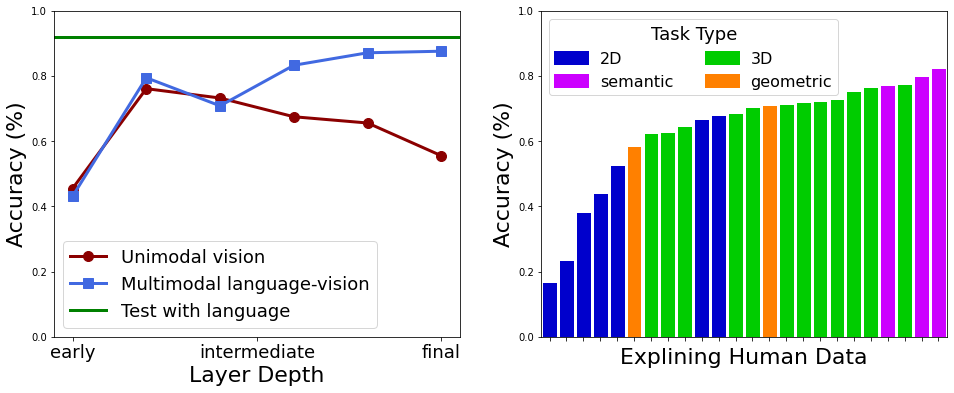

In [105]:
fig = plt.figure(figsize=(16, 6))

# language versus vision
ax = fig.add_subplot(1, 2, 1)

th = 0.5
gt = 'union'

imagenet_res = areas_accuracy(
    report_munsell_prediction(net_pred_imagenet_B32, wcs_info, th), wcs_info, gt
)
ax.plot(list(imagenet_res.values()), '-o', label='Unimodal vision', 
        color='darkred', linewidth=3, markersize=10)

clip_res = areas_accuracy(
    report_munsell_prediction(net_pred_clip_B32, wcs_info, th), wcs_info, gt
)
ax.plot(list(clip_res.values()), '-s', label='Multimodal language-vision', 
        color='royalblue', linewidth=3, markersize=10)

ax.axhline(y=language_accuracy(get_language_res('clip_B32', th), wcs_info, gt), 
                       label='Test with language', color='green', linewidth=3)

ax.set_xlabel('Layer Depth', fontsize=22)
labels = ['early', 'intermediate', 'final']
ax.set_xticks([0, 2.5, 5], labels, fontsize=18)
ax.set_ylabel('Accuracy (%)', fontsize=22)
ax.set_ylim([0, 1.0])
ax.legend(fontsize=18)

# taskonomy
ax = fig.add_subplot(1, 2, 2)

width=0.8

add_to_legends = dict()

# np.where(task_orders == task_ind)[0][0]
num_tasks = len(task_orders)
for task_ind in range(num_tasks):
    task_type = task_mapping[taskonomy_names[task_ind]].replace('x', '')
    label = None
    if task_type not in add_to_legends:
        add_to_legends[task_type] = 'done'
        label = task_type
    color = task_colours[task_type]
    ax.bar(np.where(task_orders == task_ind)[0][0], taskonomy_scores[task_ind], 
           edgecolor=color, width=width*0.8, color=color, linewidth=3, label=label)
ax.set_ylim([0, 1.0])
ax.set_xlim([-0.5, 23.5])
ax.set_xticks(np.arange(num_tasks))
ax.set_xticklabels([])
# ax.set_xticklabels(taskonomy_ordered, rotation=90)
ax.set_ylabel('Accuracy (%)', size=22)
ax.set_xlabel('Explining Human Data', size=22)
# ax.tick_params(axis='both', which='major', labelsize=22)
ax.legend(fontsize=16, ncol=2, title="Task Type", title_fontproperties={'size':18})
plt.show()